# Data Preparation

In [ ]:
# %pip install -q matplotlib 
# %pip install -q seaborn
# %pip install -q pandas
# %pip install -q numpy
# %pip install matplotlib-label-lines
# %pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 8.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 6.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 6.7 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [118]:
import matplotlib.pyplot as plt 
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
import os 
from labellines import labelLines
from sklearn import linear_model

In [99]:
png_dir = "graphs"
json_dir = "fio_results"
readme_images = []

bs_map = {
    '4K':4096,
    '16K':16384,
    '1M':1048576,
    '2M':2097152,
    '4M':4194304 
}
bs_order = [
    '4K',
    '16K',
    '1M',
    '2M',
    '4M' 
]

rw_map = {
    'read-':'Sequential Read-only',
    'rw-80':'Sequential Read-heavy 4:1',
    'rw-':'Sequential Balanced 1:1',
    'rw-20':'Sequential Write-heavy 1:4',
    'write-':'Sequential Write-only',
    'randread-':'Random Read-only',
    'randrw-80':'Random Read-heavy 4:1',
    'randrw-':'Random Balanced 1:1',
    'randrw-20':'Random Write-heavy 1:4',
    'randwrite-':'Random Write-only'
}
# wanted to use this dict to label lines.. 
marker_dict = {
    'Sequential Read-only':'SR',
    'Sequential Read-heavy 4:1':'SRH',
    'Sequential Balanced 1:1':'SB',
    'Sequential Write-heavy 1:4':'SWH',
    'Sequential Write-only':'SW',
    'Random Read-only':'RR',
    'Random Read-heavy 4:1':'RRH',
    'Random Balanced 1:1':'RB',
    'Random Write-heavy 1:4':'RWH',
    'Random Write-only':'RW'
}
hue_order = ['Sequential Read-only','Sequential Read-heavy 4:1','Sequential Balanced 1:1','Sequential Write-heavy 1:4','Sequential Write-only','Random Read-only','Random Read-heavy 4:1','Random Balanced 1:1','Random Write-heavy 1:4','Random Write-only']
sequential_full = ['Sequential Read-only','Sequential Read-heavy 4:1','Sequential Balanced 1:1','Sequential Write-heavy 1:4','Sequential Write-only']
random_full = ['Random Read-only','Random Read-heavy 4:1','Random Balanced 1:1','Random Write-heavy 1:4','Random Write-only']

sns.set_style("whitegrid")
# palette = sns.color_palette("magma", 10) 
palette = sns.color_palette("flare", 5) + sns.color_palette("crest", 5)

# parameters to display in this notebook
# just to view an example graph from looped graph generations and to avoid crowded notebook
DISPLAY_BS = '2M'
DISPLAY_NJ = 16
DISPLAY_IOD = 1

In [100]:
# Assemble columns names
rwfile = 'fio_rw_json_example.json'
mixfile = 'fio_mix_json_example.json'
cols = pd.json_normalize(pd.read_json(rwfile)['jobs']).columns.tolist() + pd.json_normalize(pd.read_json(mixfile)['jobs']).columns.tolist() 
cols = list(set(cols))


# Read in json files
first = True
df = pd.DataFrame()
frames = []
for file_name in os.listdir(json_dir):
    if file_name.endswith('.json'): 
        file = os.path.join(json_dir, file_name)
        # print(file_name)
    
        tmp = pd.json_normalize(pd.read_json(file)['jobs'])
        # tmp = tmp.reindex(columns=cols)
    
        for col in tmp.select_dtypes(include=['int', 'int64', 'int32']).columns:
            tmp[col] = tmp[col].astype(float)
    
        frames.append(tmp)
        # if first:
        #     df = tmp
        #     first = False
        # else:
        #     # df = pd.merge(tmp, df, how="outer", on=cols)
        #     df = pd.concat([tmp, df], ignore_index=True)
df = pd.concat(frames, ignore_index=True)
df = df.copy()

df.to_csv("fio_results.csv")
print(f'\nChecking for incomplete runs....\nRuns with <60 seconds elapsed time:\n{df[df['elapsed'] < 60]}')



Checking for incomplete runs....
Runs with <60 seconds elapsed time:
Empty DataFrame
Columns: [jobname, groupid, error, eta, elapsed, job_runtime, usr_cpu, sys_cpu, ctx, majf, minf, latency_depth, latency_target, latency_percentile, latency_window, job options.name, job options.numjobs, job options.runtime, job options.directory, job options.direct, job options.buffered, job options.rw, job options.unified_rw_reporting, job options.randrepeat, job options.bs, job options.size, job options.ioengine, job options.iodepth, job options.lat_percentiles, mixed.io_bytes, mixed.io_kbytes, mixed.bw_bytes, mixed.bw, mixed.iops, mixed.runtime, mixed.total_ios, mixed.short_ios, mixed.drop_ios, mixed.slat_ns.min, mixed.slat_ns.max, mixed.slat_ns.mean, mixed.slat_ns.stddev, mixed.slat_ns.N, mixed.clat_ns.min, mixed.clat_ns.max, mixed.clat_ns.mean, mixed.clat_ns.stddev, mixed.clat_ns.N, mixed.clat_ns.percentile.1.000000, mixed.clat_ns.percentile.5.000000, mixed.clat_ns.percentile.10.000000, mixed.cla

In [101]:
# Set up columns and data types

#### COLUMN NAMES ####
#####   Variables:  
# "job options.iodepth" : io depth
# "job options.numjobs" : number of jobs
# "job options.bs" : block size
# "rw_full" : read write type (human readable)
#
#####   Outputs:    
# "bw_mean" : mean bandwidth
# "iops" : iops
# "lat_ns.mean" : mean latency
# "lat_ns.percentile.99.000000" : 99% latency
######################

# Read-Write
df['rw_code'] = df['job options.rw'].str.cat(df['job options.rwmixread'], sep='-', na_rep='')
df["rw_full"] = df["rw_code"].map(rw_map)

# Block Size 
df['bs_num'] = df['job options.bs'].map(bs_map)
df['bs_num'] = df['bs_num'].astype(int)

# Number of Jobs
df["job options.numjobs"] = df["job options.numjobs"].astype(int)

# IO Depth
df["job options.iodepth"] = df["job options.iodepth"].astype(int)

# Helper function to get random/sequential category column
def rand_or_seq(rw_full):
    if rw_full in random_full:
        return 'random'
    elif rw_full in sequential_full:
        return 'sequential'
    else:
        return -1
df['rand_seq_type'] = df['rw_full'].apply(rand_or_seq)

# Helper function to combine mixed/read/write outputs into one column for plotting
def get_var(row, colname):
    var_cols = ['mixed.'+colname, 'read.'+colname, 'write.'+colname]
    for col in var_cols:
        if col in row.index:
            var = row[col]
            if pd.notna(var) and var != 0:
                return var, col
    return np.nan, None

# Bandwidth
df['bw_mean']  = df.apply(lambda row: get_var(row, 'bw_mean')[0], axis=1)
df['bw_mean'] = df['bw_mean']/(1024*1024)

# Iops
df['iops'] = df.apply(lambda row: get_var(row, 'iops')[0], axis=1)
df['iops'] = df['iops'].astype(int)

# Latency
df['lat_ns.mean'] = df.apply(lambda row: get_var(row, 'lat_ns.mean')[0], axis=1)
df['lat_s.mean'] = df['lat_ns.mean']/1e9
df['lat_ns.percentile.99.000000'] = df.apply(lambda row: get_var(row, 'lat_ns.percentile.99.000000')[0], axis=1)
df['lat_s.percentile.99.000000'] = df['lat_ns.percentile.99.000000']/1e9


# Minimums and Maximums

In [102]:
# Get diagnostics over entire dataset
maxes = df.idxmax(numeric_only=True)
mins = df.idxmin(numeric_only=True)

print(f'\nMaximum Bandwidth: {max(df['bw_mean'])} GiB/s when \n\tIO Depth = {df.iloc[maxes['bw_mean']]["job options.iodepth"]}, \n\t# Jobs = {df.iloc[maxes['bw_mean']]["job options.numjobs"]}, \n\tBlock Size = {df.iloc[maxes['bw_mean']]["job options.bs"]}, \n\tRead/Write Type = {df.iloc[maxes['bw_mean']]["rw_full"]}')

print(f'\nMaximum IOPS: {max(df['iops'])} when \n\tIO Depth = {df.iloc[maxes['iops']]["job options.iodepth"]}, \n\t# Jobs = {df.iloc[maxes['iops']]["job options.numjobs"]}, \n\tBlock Size = {df.iloc[maxes['iops']]["job options.bs"]}, \n\tRead/Write Type = {df.iloc[maxes['iops']]["rw_full"]}')

print(f'\nMinimum Latency (mean): {min(df['lat_ns.mean'])/1e9} s ({min(df['lat_ns.mean'])} ns) when \n\tIO Depth = {df.iloc[mins['lat_ns.mean']]["job options.iodepth"]}, \n\t# Jobs = {df.iloc[mins['lat_ns.mean']]["job options.numjobs"]}, \n\tBlock Size = {df.iloc[mins['lat_ns.mean']]["job options.bs"]}, \n\tRead/Write Type = {df.iloc[mins['lat_ns.mean']]["rw_full"]}')

print(f'\nMinimum Latency (99 percentile): {min(df['lat_ns.percentile.99.000000'])/1e9} s ({min(df['lat_ns.percentile.99.000000'])} ns) when \n\tIO Depth = {df.iloc[mins['lat_ns.percentile.99.000000']]["job options.iodepth"]}, \n\t# Jobs = {df.iloc[mins['lat_ns.percentile.99.000000']]["job options.numjobs"]}, \n\tBlock Size = {df.iloc[mins['lat_ns.percentile.99.000000']]["job options.bs"]}, \n\tRead/Write Type = {df.iloc[mins['lat_ns.percentile.99.000000']]["rw_full"]}')


Maximum Bandwidth: 14.375768425355911 GiB/s when 
	IO Depth = 16, 
	# Jobs = 128, 
	Block Size = 2M, 
	Read/Write Type = Sequential Write-only

Maximum IOPS: 80284 when 
	IO Depth = 8, 
	# Jobs = 32, 
	Block Size = 16K, 
	Read/Write Type = Random Write-only

Minimum Latency (mean): 0.000218020866563 s (218020.866563 ns) when 
	IO Depth = 32, 
	# Jobs = 16, 
	Block Size = 4K, 
	Read/Write Type = Sequential Write-only

Minimum Latency (99 percentile): 0.000313344 s (313344.0 ns) when 
	IO Depth = 16, 
	# Jobs = 16, 
	Block Size = 4K, 
	Read/Write Type = Random Write-only


# Looking at variable relationships

In [ ]:
#####   Variables:  
# "job options.iodepth" : io depth
# "job options.numjobs" : number of jobs
# "job options.bs" : block size
# "rw_full" : read write type (human readable)
#
#####   Outputs:    
# "bw_mean" : mean bandwidth
# "iops" : iops
# "lat_ns.mean" : mean latency
# "lat_ns.percentile.99.000000" : 99% latency
######################

X = df[['job options.iodepth', 'job options.numjobs', 'job options.bs', 'rw_full']]
X = pd.get_dummies(data=X)
# print(X.head())
bw = df['bw_mean']
iops = df['iops']
lat_mean = df['lat_ns.mean']
lat_99 = df['lat_ns.percentile.99.000000']

print("\nBandwidth Regression Weights: ")
bw_reg = linear_model.LinearRegression()
bw_reg.fit(X,bw)
for feature, weight in zip(X.columns, bw_reg.coef_):
    print(f'{feature}: {weight:.4f}')

print("\nIOPS Regression Weights: ")
iops_reg = linear_model.LinearRegression()
iops_reg.fit(X,iops)
for feature, weight in zip(X.columns, iops_reg.coef_):
    print(f'{feature}: {weight:.4f}')

print("\nLatency (mean) Regression Weights: ")
lat_mean_reg = linear_model.LinearRegression()
lat_mean_reg.fit(X,lat_mean)
for feature, weight in zip(X.columns, lat_mean_reg.coef_):
    print(f'{feature}: {weight:.4f}')


print("\nLatency (99%) Regression Weights: ")
lat_99_reg = linear_model.LinearRegression()
lat_99_reg.fit(X,lat_99)
for feature, weight in zip(X.columns, lat_99_reg.coef_):
    print(f'{feature}: {weight:.4f}')


Bandwidth Regression Weights: 
job options.iodepth: -0.0002
job options.numjobs: -0.0002
job options.bs_16K: -2.5563
job options.bs_1M: 1.9734
job options.bs_2M: 1.8893
job options.bs_4K: -3.1375
job options.bs_4M: 1.8311
rw_full_Random Balanced 1:1: -0.9068
rw_full_Random Read-heavy 4:1: -1.3834
rw_full_Random Read-only: -1.5372
rw_full_Random Write-heavy 1:4: 0.5042
rw_full_Random Write-only: 3.6608
rw_full_Sequential Balanced 1:1: -0.9431
rw_full_Sequential Read-heavy 4:1: -1.4321
rw_full_Sequential Read-only: -1.5658
rw_full_Sequential Write-heavy 1:4: 0.3863
rw_full_Sequential Write-only: 3.2172

IOPS Regression Weights: 
job options.iodepth: 6.0731
job options.numjobs: -6.4400
job options.bs_16K: 28450.8629
job options.bs_1M: -17212.1550
job options.bs_2M: -19975.6407
job options.bs_4K: 30080.1200
job options.bs_4M: -21343.1871
rw_full_Random Balanced 1:1: -1471.8300
rw_full_Random Read-heavy 4:1: -3196.2586
rw_full_Random Read-only: -3929.5657
rw_full_Random Write-heavy 1:4: 12

Variable relationships, in part so I don't lose the big picture


```
Bandwidth Regression Weights: 

job options.iodepth: -0.0002
job options.numjobs: -0.0002
job options.bs_16K: -2.5563
job options.bs_1M: 1.9734
job options.bs_2M: 1.8893
job options.bs_4K: -3.1375
job options.bs_4M: 1.8311
rw_full_Random Balanced 1:1: -0.9068
rw_full_Random Read-heavy 4:1: -1.3834
rw_full_Random Read-only: -1.5372
rw_full_Random Write-heavy 1:4: 0.5042
rw_full_Random Write-only: 3.6608
rw_full_Sequential Balanced 1:1: -0.9431
rw_full_Sequential Read-heavy 4:1: -1.4321
rw_full_Sequential Read-only: -1.5658
rw_full_Sequential Write-heavy 1:4: 0.3863
rw_full_Sequential Write-only: 3.2172
```

- numjobs and iodepth have equally small effects on bandwidth, decreasing it
- block size of 1M has the most effect on increasing bandwidth, closely followed by 2M and 4M (many block size series peak at 2M)
- more writing --> higher bandwidth

```
IOPS Regression Weights: 

job options.iodepth: 6.0731
job options.numjobs: -6.4400
job options.bs_16K: 28450.8629
job options.bs_1M: -17212.1550
job options.bs_2M: -19975.6407
job options.bs_4K: 30080.1200
job options.bs_4M: -21343.1871
rw_full_Random Balanced 1:1: -1471.8300
rw_full_Random Read-heavy 4:1: -3196.2586
rw_full_Random Read-only: -3929.5657
rw_full_Random Write-heavy 1:4: 1284.2486
rw_full_Random Write-only: 5410.4771
rw_full_Sequential Balanced 1:1: -651.5800
rw_full_Sequential Read-heavy 4:1: -2686.0800
rw_full_Sequential Read-only: -4205.7800
rw_full_Sequential Write-heavy 1:4: 2445.4914
rw_full_Sequential Write-only: 7000.8771
```
- iodepth and numjobs' effects are similar in magnitude
- higher iodepth increases IOPS, higher numjobs decreases IOPS
- smaller block size --> higher IOPS, larger block size --> lower IOPS
- more writing --> higher IOPS, more reading --> lower IOPS

Latency (mean) Regression Weights: 
job options.iodepth: -9910.0998
job options.numjobs: 464839.6965
job options.bs_16K: -23962546.5635
job options.bs_1M: -8942864.9126
job options.bs_2M: 9737824.1674
job options.bs_4K: -23999205.3594
job options.bs_4M: 47166792.6681
rw_full_Random Balanced 1:1: 20081.7507
rw_full_Random Read-heavy 4:1: 10365058.2856
rw_full_Random Read-only: 15909472.0372
rw_full_Random Write-heavy 1:4: -11089894.9681
rw_full_Random Write-only: -18238655.9998
rw_full_Sequential Balanced 1:1: 1163474.8858
rw_full_Sequential Read-heavy 4:1: 12337015.7854
rw_full_Sequential Read-only: 17158123.3711
rw_full_Sequential Write-heavy 1:4: -10035534.3796
rw_full_Sequential Write-only: -17589140.7684

Latency (99%) Regression Weights: 
job options.iodepth: -183232.9590
job options.numjobs: 1270815.0317
job options.bs_16K: -85772350.9029
job options.bs_1M: -14840302.4457
job options.bs_2M: 50631507.3829
job options.bs_4K: -85661378.5600
job options.bs_4M: 135642524.5257
rw_full_Random Balanced 1:1: -2275134.9029
rw_full_Random Read-heavy 4:1: 6043446.1257
rw_full_Random Read-only: 1433076.2971
rw_full_Random Write-heavy 1:4: -23701457.1886
rw_full_Random Write-only: -62901917.9886
rw_full_Sequential Balanced 1:1: 32173980.5257
rw_full_Sequential Read-heavy 4:1: 50429486.8114
rw_full_Sequential Read-only: 43251948.9829
rw_full_Sequential Write-heavy 1:4: -1868840.9600
rw_full_Sequential Write-only: -42584587.7029

# Bandwidth Plots

## Bandwidth vs Number of Jobs

### Overview Grids

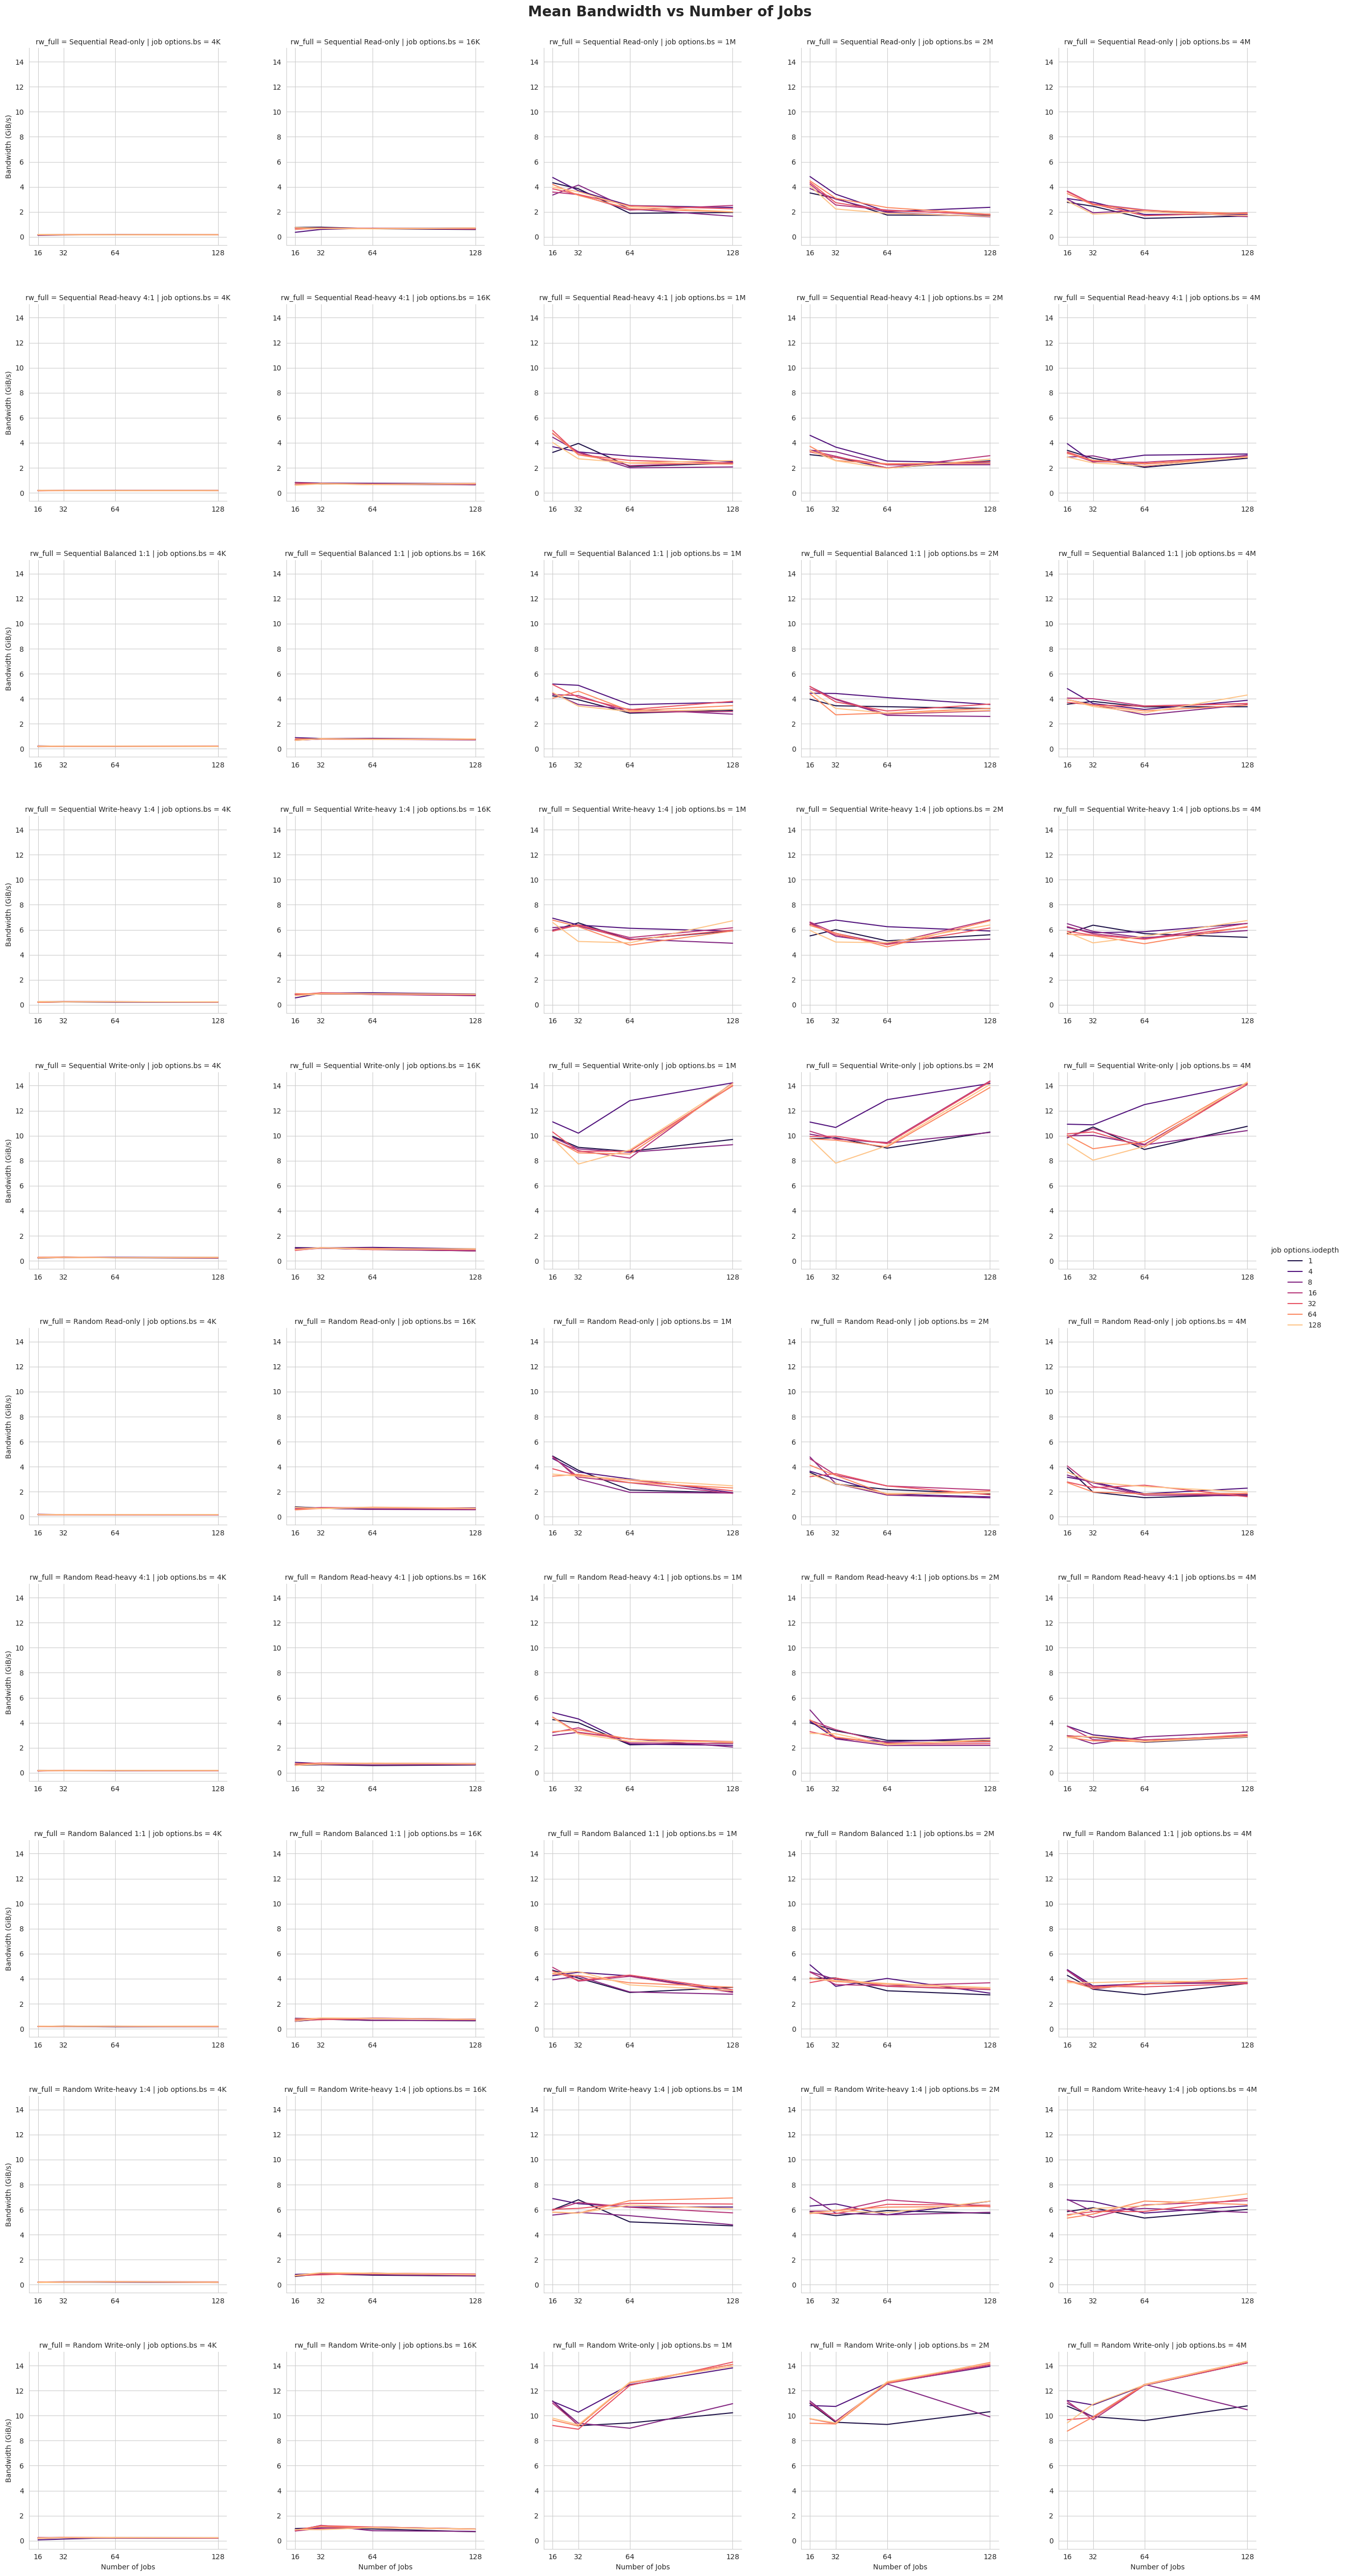

<Figure size 640x480 with 0 Axes>

In [103]:
# Y:    BANDWIDTH
# X:    NUMBER OF JOBS
# LINE: IO DEPTH

palette = sns.color_palette("magma", len(df['job options.iodepth'].unique()))

g = sns.relplot(data=df,
                kind="line",
                x="job options.numjobs",
                hue="job options.iodepth", 
                y="bw_mean",
                col="job options.bs",
                row="rw_full",
                palette=palette,
                col_order=bs_order,
                row_order=hue_order
                )

g.set_ylabels("Bandwidth (GiB/s)")
g.set_xlabels("Number of Jobs")
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
g.figure.suptitle("Mean Bandwidth vs Number of Jobs", fontsize=20, weight="bold", x = 0.5, y=1.01)
for i, ax in enumerate(g.axes.flat):
    ax.set_xticks(df["job options.numjobs"].unique())
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )

img_path = (png_dir + "/fio_bandwidth/fio_bw_vs_nj_hueIOD_allD.svg")
plt.savefig(img_path, bbox_inches="tight")
readme_images.append(img_path)
plt.show()
plt.clf()

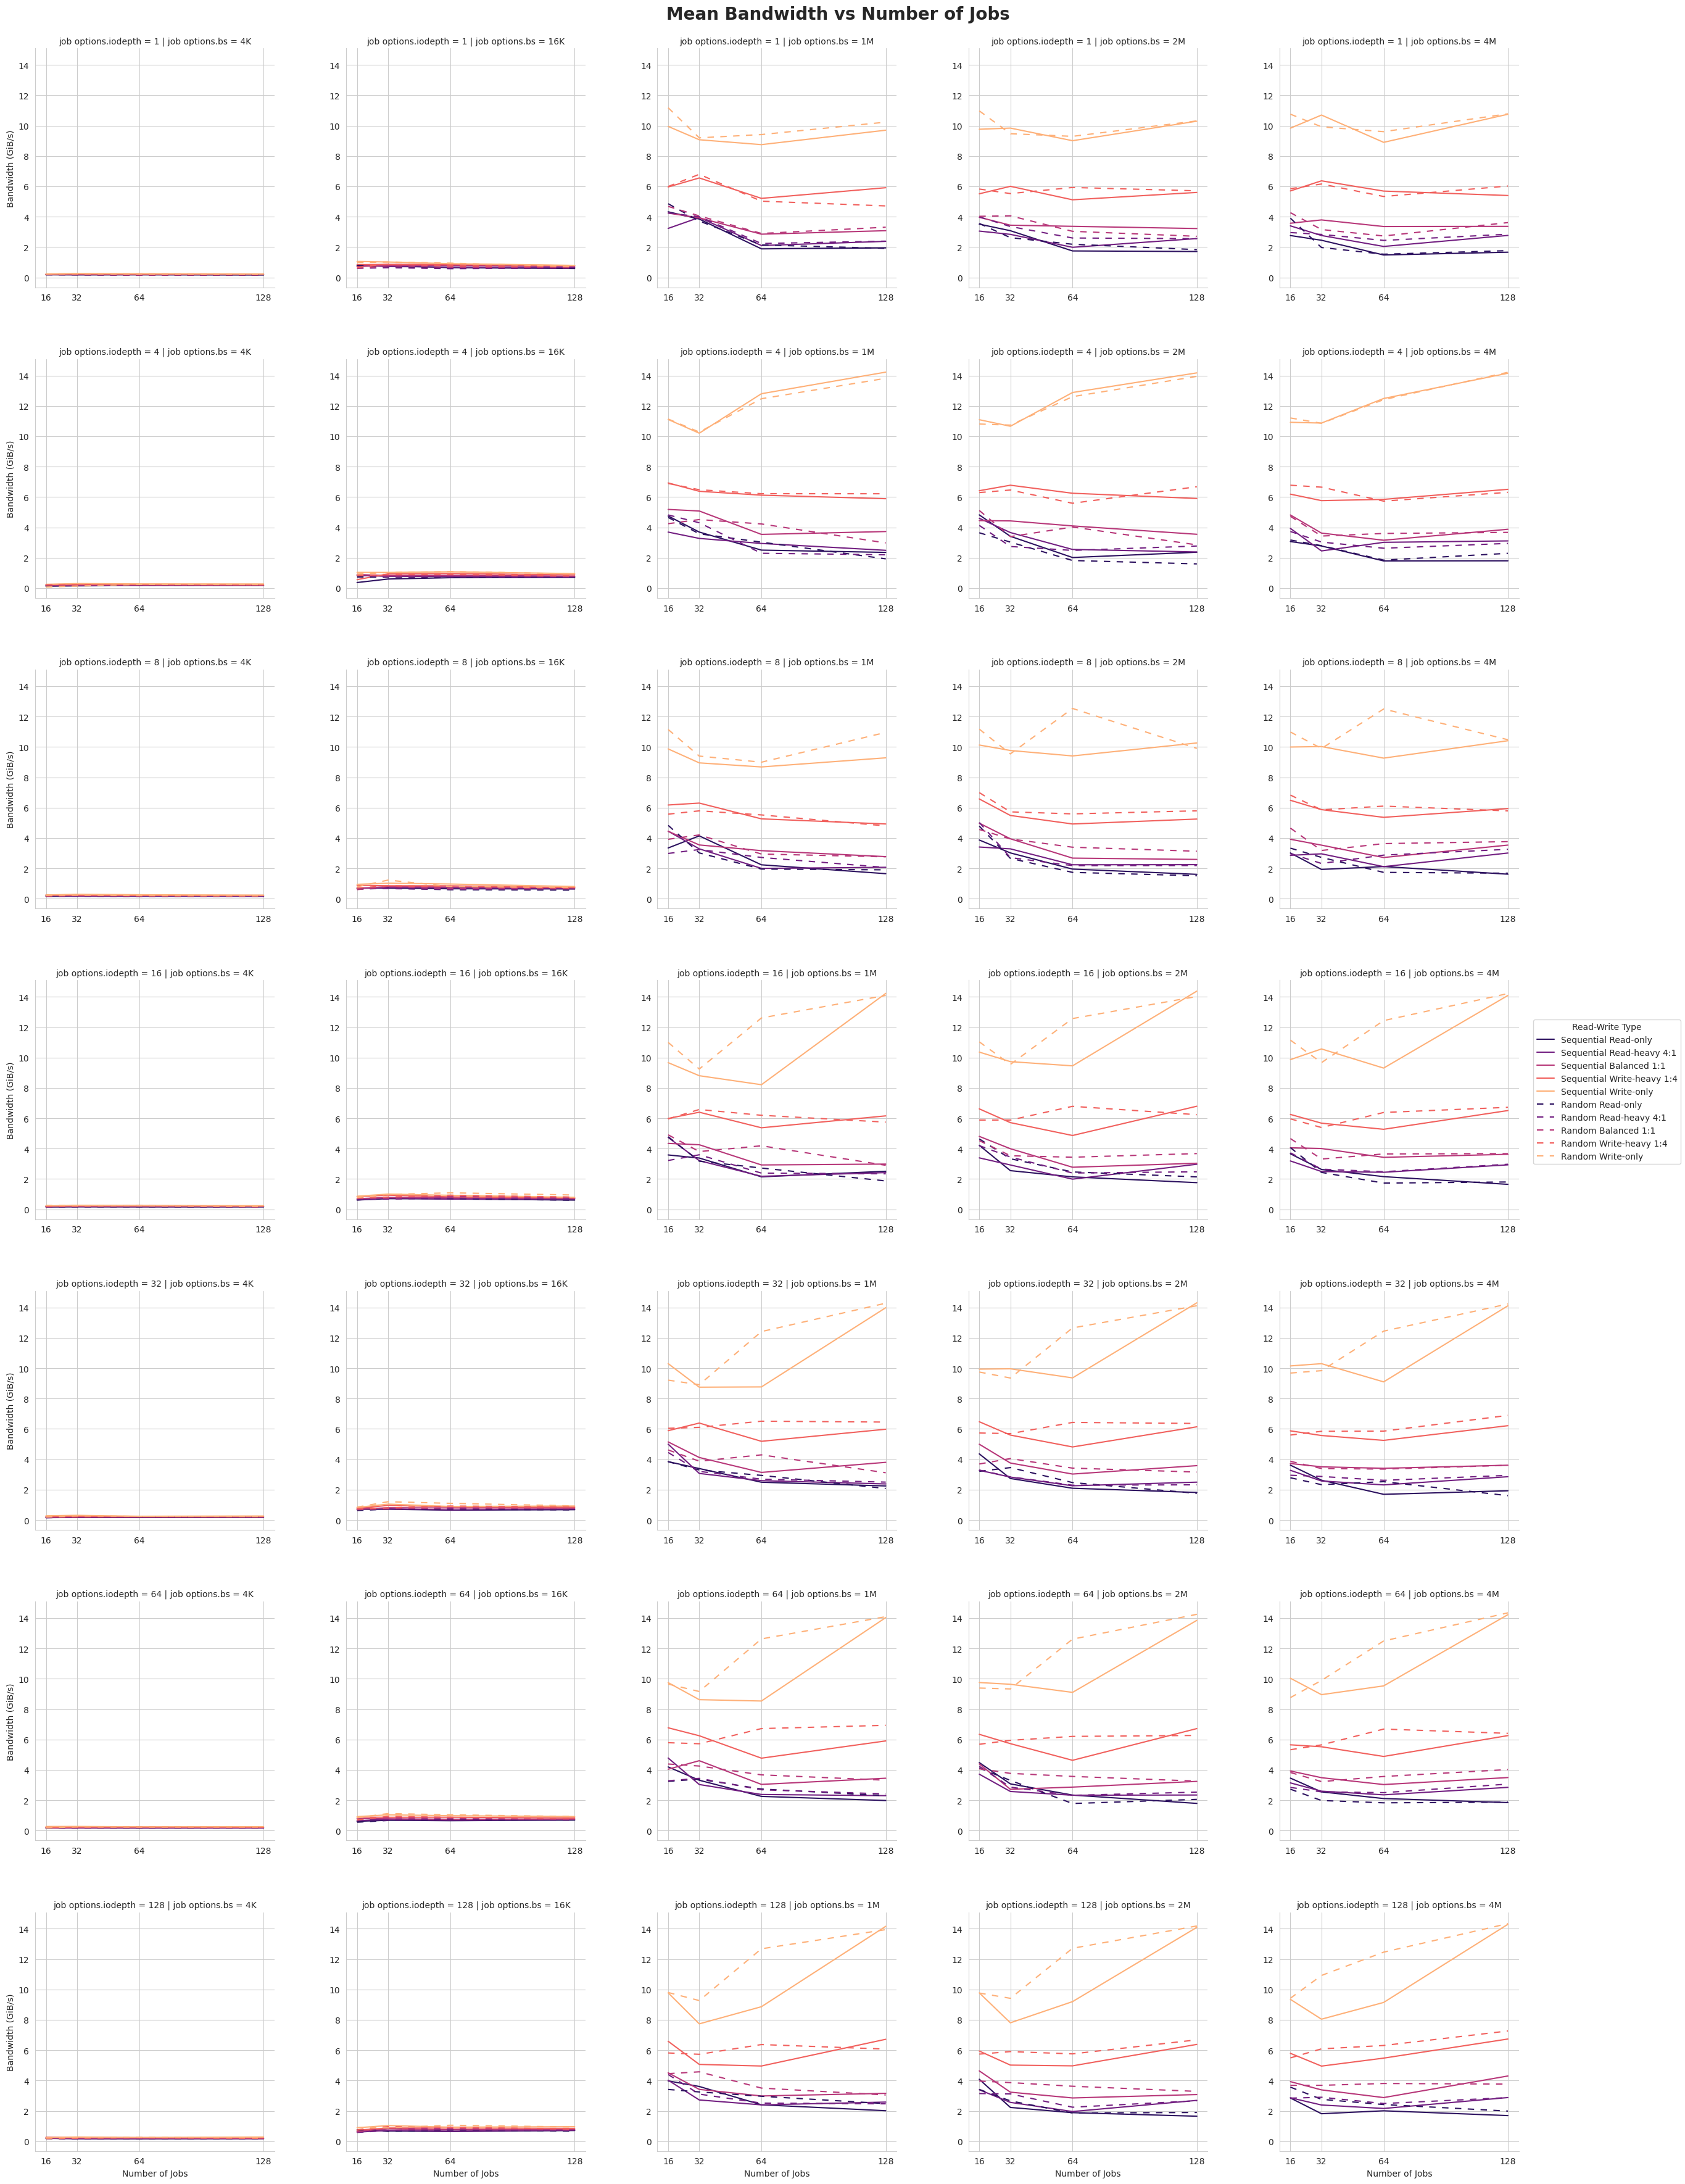

<Figure size 640x480 with 0 Axes>

In [104]:
# Y:    BANDWIDTH
# X:    NUMBER OF JOBS
# LINE: READ-WRITE TYPE

palette = sns.color_palette("magma", 5) + sns.color_palette("magma", 5)
dashes = {'sequential': '', 'random': (5, 5) }

g = sns.relplot(data=df,
                kind="line",
                x="job options.numjobs",
                hue="rw_full", 
                y="bw_mean",
                row="job options.iodepth",
                col="job options.bs",
                style="rand_seq_type",
                dashes=dashes,
                palette=palette,
                hue_order=hue_order,
                col_order=bs_order,
                )

g.set_ylabels("Bandwidth (GiB/s)")
g.set_xlabels("Number of Jobs")
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
g.figure.suptitle("Mean Bandwidth vs Number of Jobs", fontsize=20, weight="bold", x = 0.5, y=1.01)
for i, ax in enumerate(g.axes.flat):
    ax.set_xticks(df["job options.numjobs"].unique())
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )

lines =  g.axes.flat[0] .get_lines()
lines = [l for l in lines if len(l.get_ydata()) > 0] 

g._legend.remove()
g.figure.legend(
    handles=lines,
    labels=hue_order, 
    title='Read-Write Type',
    loc='center right'
)

img_path = (png_dir + "/fio_bandwidth/fio_bw_vs_nj_hueRW_allD.svg")
plt.savefig(img_path, bbox_inches="tight")
readme_images.append(img_path)
plt.show()
plt.clf()

### Individual Plots

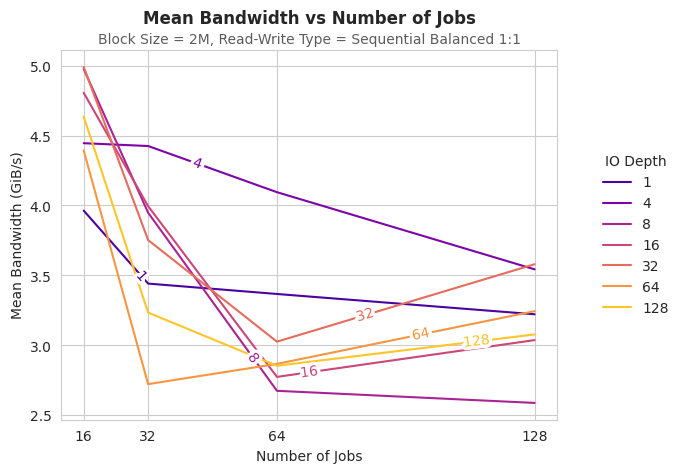

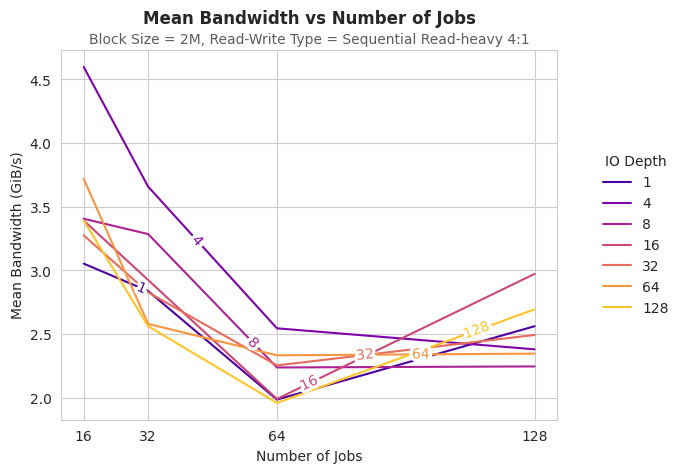

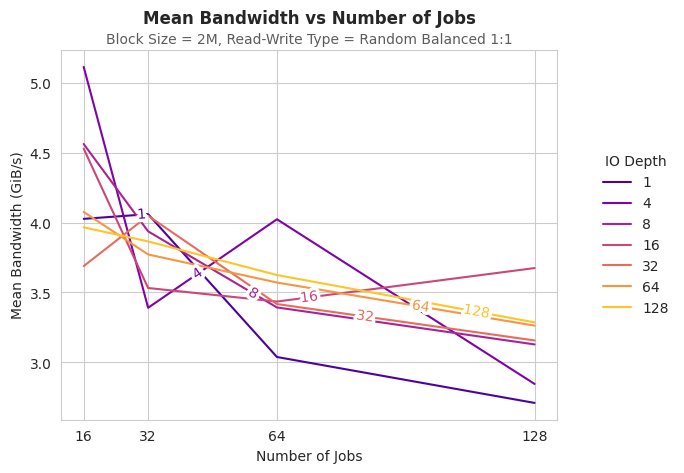

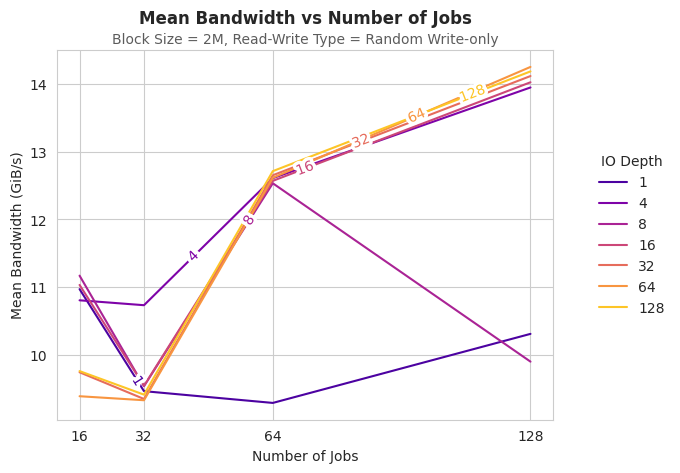

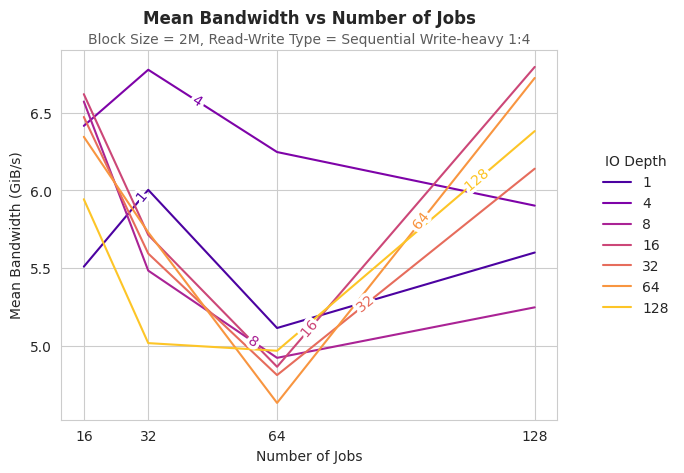

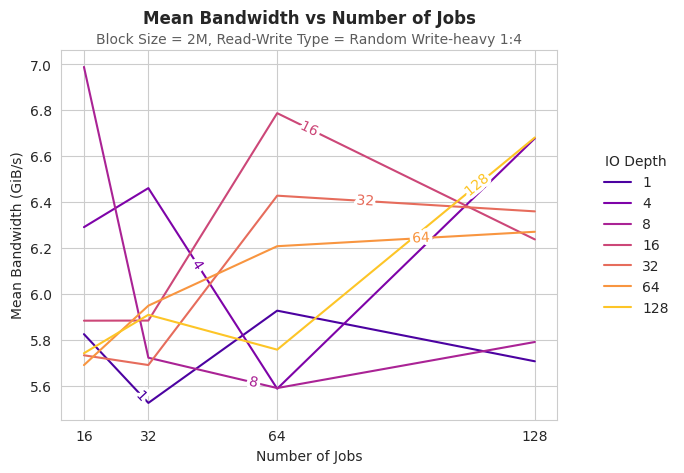

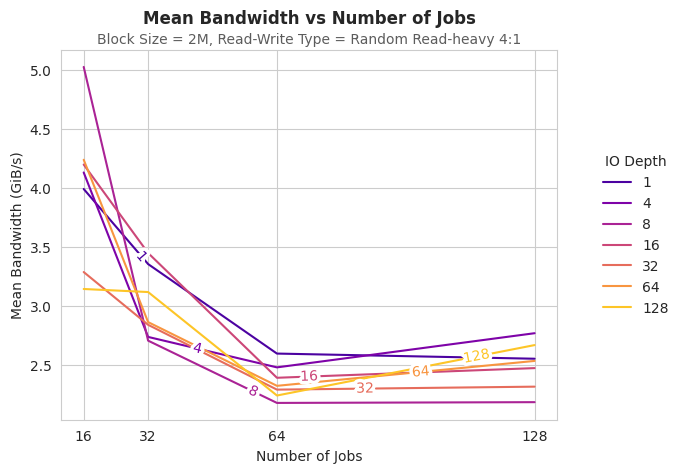

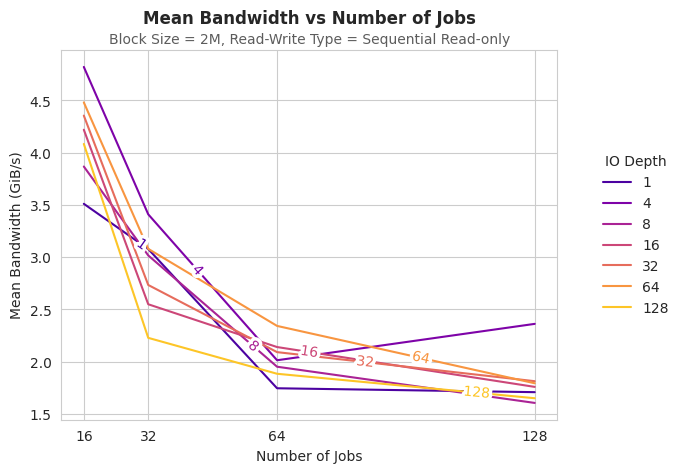

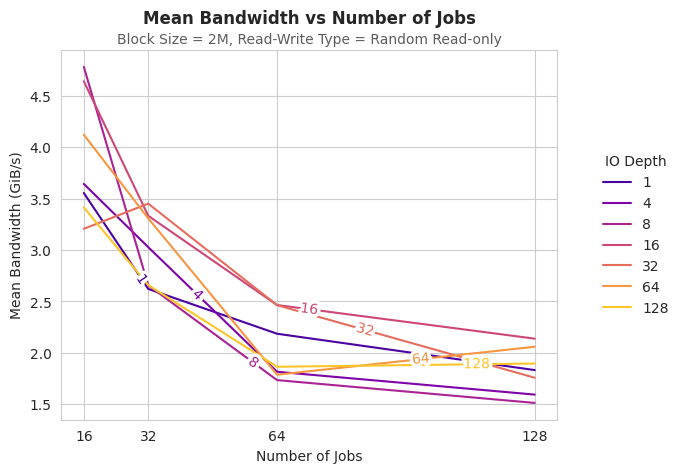

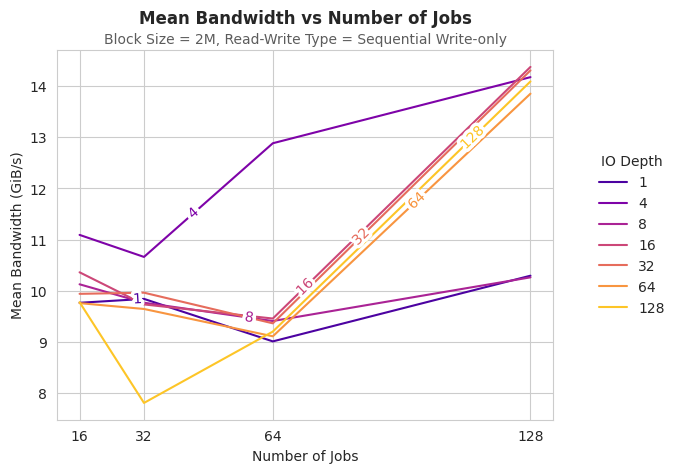

<Figure size 640x480 with 0 Axes>

In [105]:
# Y:    BANDWIDTH
# X:    NUMBER OF JOBS
# LINE: IO DEPTH

palette = sns.color_palette("plasma", len(df['job options.iodepth'].unique()))

for rw in df["rw_full"].unique():
    for bs in df["job options.bs"].unique():
        subdf = df[ (df["rw_full"] == rw) & (df["job options.bs"] == bs) ]
        dashes = { 'sequential': '',  'random': (5, 5) }
        ax = sns.lineplot(
            data=subdf,
            x="job options.numjobs",
            y="bw_mean",
            hue="job options.iodepth", 
            palette=palette
        )
        ax.set_xticks(subdf["job options.numjobs"].unique())
        ax.set_xlabel("Number of Jobs")
        ax.set_ylabel("Mean Bandwidth (GiB/s)")
        ax.set_title("Mean Bandwidth vs Number of Jobs", weight="bold", x=0.5, y=1.05)
        ax.text(x=0.5, y=1.01, 
                    s=f"Block Size = {bs}, Read-Write Type = {rw}", 
                    fontsize=10, alpha=0.75, ha='center', va='bottom', 
                    transform=ax.transAxes)

        lines = ax.get_lines()
        lines = [l for l in lines if len(l.get_ydata())>0]
        handles, labels = ax.get_legend_handles_labels()
        labels = [label for label in labels if label in str(subdf['job options.iodepth'].unique().tolist()) ]

        for line, label in zip(lines, labels):
            line.set_label(label)
       
        labelLines(lines)

        ax.legend(
            loc='center right',
            handles=lines,
            labels=labels,
            bbox_to_anchor=(1.25,.5),
            title='IO Depth',
            frameon=False
        )

        rw_c = subdf.iloc[0]['rw_code']
        # print(rw_c)
        img_path = (png_dir + f"/fio_bandwidth/fio_bw_vs_nj_hueIOD_rw-{rw_c}_bs-{bs}.svg")
        plt.savefig(img_path, bbox_inches="tight")
        # REMOVE IF STATEMENT TO SEE ALL
        if (bs==DISPLAY_BS):
            readme_images.append(img_path)
            plt.show()
        plt.clf()

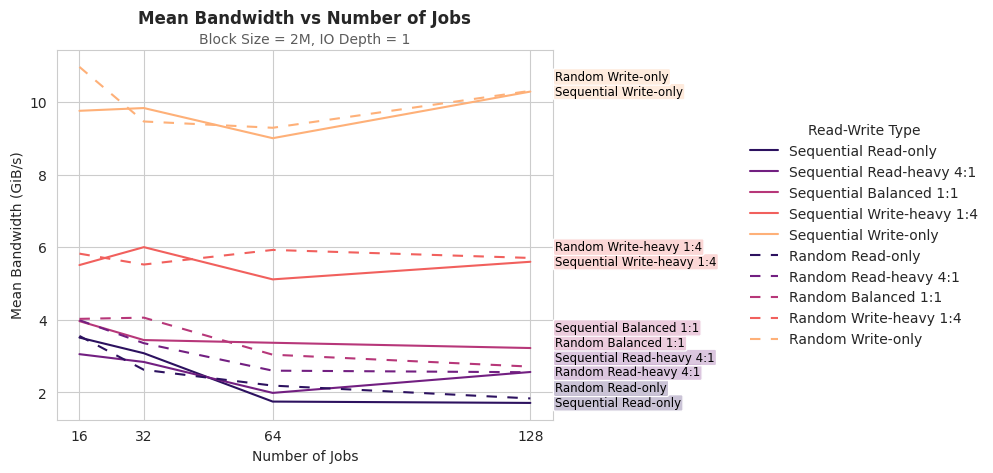

<Figure size 640x480 with 0 Axes>

In [106]:
# Y:    BANDWIDTH
# X:    NUMBER OF JOBS
# LINE: READ-WRITE TYPE

palette = sns.color_palette("magma", 5) + sns.color_palette("magma", 5)
for iod in df["job options.iodepth"].unique():
    for bs in df["job options.bs"].unique():
        subdf = df[ (df["job options.iodepth"] == iod) & (df["job options.bs"] == bs) ]
        rows, cols = subdf.shape
        if rows >0:
            dashes = {
                'sequential': '',  # solid
                'random': (5, 5)  # dashed
            }
            ax = sns.lineplot(
                data=subdf,
                x="job options.numjobs",
                y="bw_mean",
                hue="rw_full", 
                style="rand_seq_type", dashes=dashes,
                # marker='o',
                hue_order=hue_order,
                # order=bs_order,
                palette=palette
            )
            ax.set_xticks(subdf["job options.numjobs"].unique())
            ax.set_xlabel("Number of Jobs")
            ax.set_ylabel("Mean Bandwidth (GiB/s)")
            ax.set_title("Mean Bandwidth vs Number of Jobs", weight="bold", x=0.5, y=1.05)

            ax.text(x=0.5, y=1.01, 
                    s=f"Block Size = {bs}, IO Depth = {iod}", 
                    fontsize=10, alpha=0.75, ha='center', va='bottom', 
                    transform=ax.transAxes)
            ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type', loc="upper left")

            # get lines and labels
            lines = ax.get_lines()
            lines = [l for l in lines if len(l.get_ydata())>0]

            handles, labels = ax.get_legend_handles_labels()
            labels = [label for label in labels if label in subdf['rw_full'].unique().tolist() ]

            end_points = sorted(
                [(h.get_ydata()[-1], h, l) for h, l in zip(lines, labels)],
                key=lambda tup: tup[0]
            )
            # set positions of labels
            y_positions = []
            min_gap = 0.04 * (ax.get_ylim()[1] - ax.get_ylim()[0]) 

            x_pos = 0
            y_pos = 0
            for line in lines:
                x_pos = max(x_pos, line.get_xdata()[-1] + 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0]))

            for i, (y, line, label) in enumerate(end_points):
                if i == 0:
                    y_pos = y
                else:
                    y_pos = max( y, y_positions[-1] + min_gap )
                # if i < 5:
                #     y_pos -= 0.1
                y_positions.append(y_pos)

                # highlighted lables
                stroke_color = mcolors.to_rgba(line.get_color(), alpha=0.25)
                ax.text(x_pos, y_pos, label, color='black',
                        bbox=dict( boxstyle='round,pad=0.15', facecolor=stroke_color),
                        va='center', fontsize=8.5)
                
            legend_x = x_pos + 0.4*(ax.get_xlim()[1] - ax.get_xlim()[0]) 
            legend_y = 0.5  

            ax.legend(
                loc='center left',
                labels=hue_order,
                handles=lines,
                bbox_to_anchor=(legend_x / ax.get_xlim()[1], legend_y),  
                title='Read-Write Type',
                frameon=False
            )

            # ax.legend_.remove()
            img_path = (png_dir + f"/fio_bandwidth/fio_bw_vs_nj_hueRW_iod-{iod}_bs-{bs}.svg")
            plt.savefig(img_path, bbox_inches="tight")
            if (bs==DISPLAY_BS and iod==DISPLAY_IOD):
                readme_images.append(img_path)
                plt.show()
            plt.clf()

## Bandwidth vs IO Depth

### Overview Grids

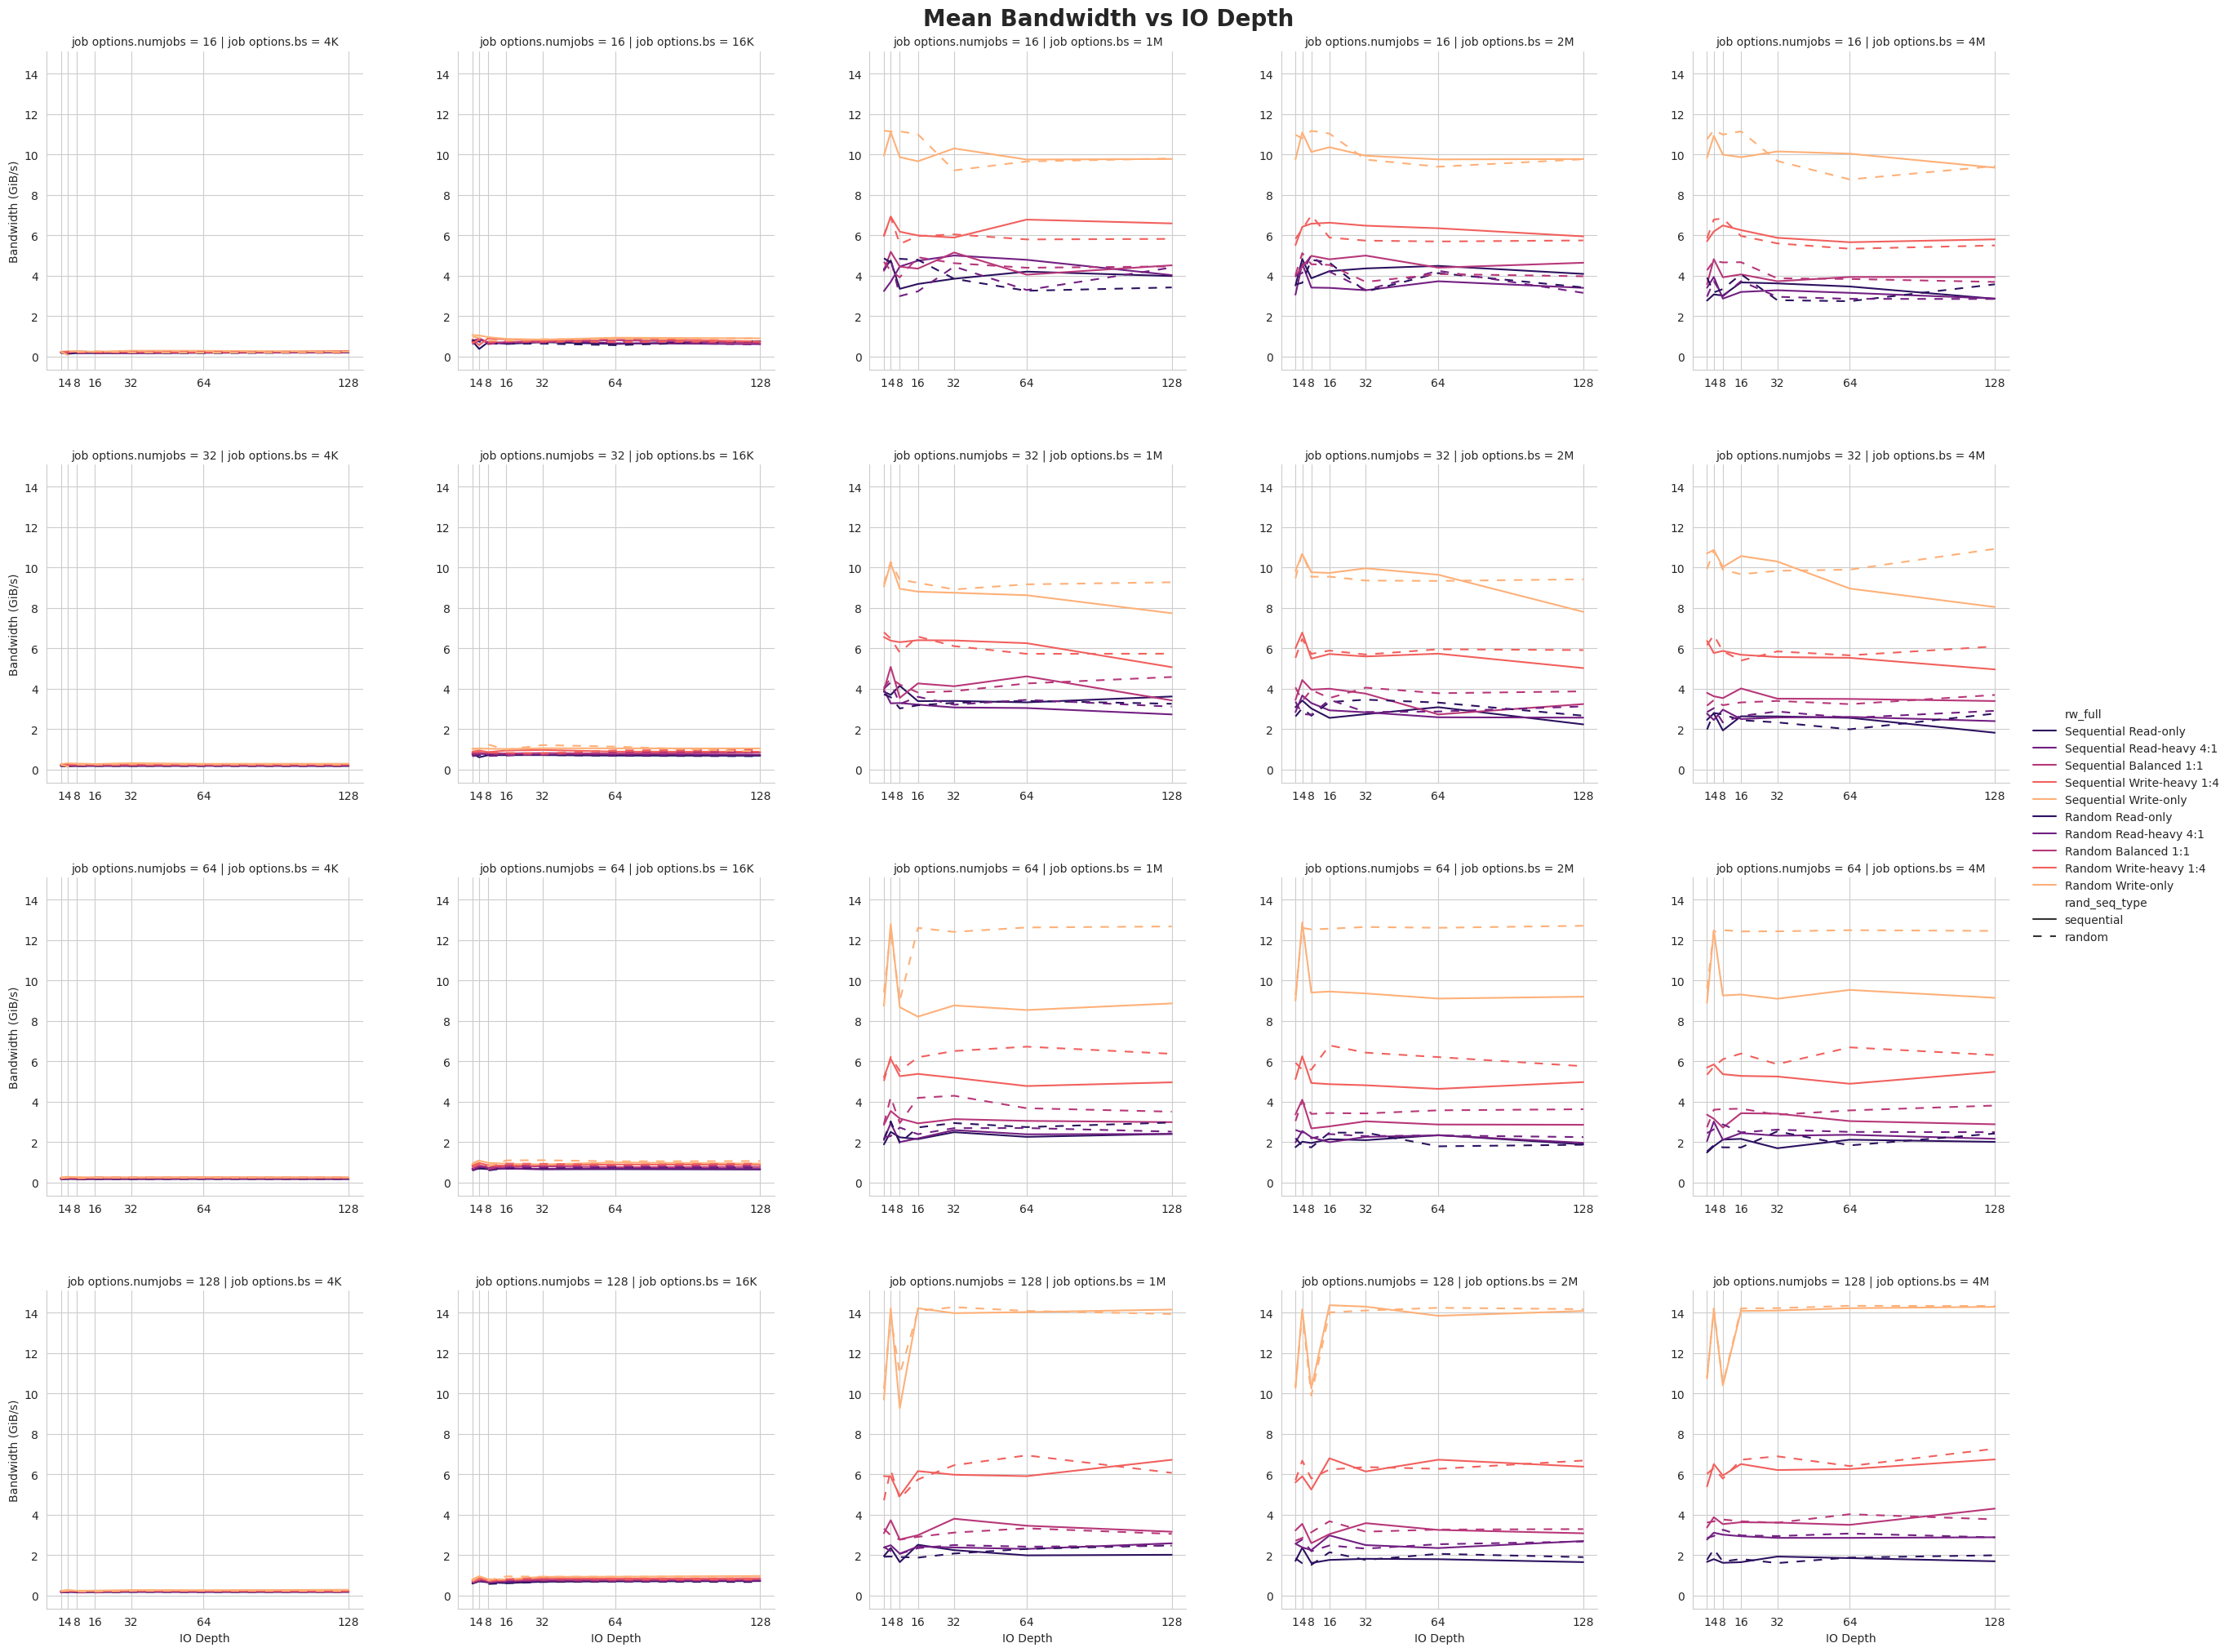

<Figure size 640x480 with 0 Axes>

In [107]:
# Y:    BANDWIDTH
# X:    IO DEPTH
# LINE: READ-WRITE TYPE

palette = sns.color_palette("magma", 5) + sns.color_palette("magma", 5)

dashes = {'sequential': '', 'random': (5, 5) }

g = sns.relplot(data=df,
                kind="line",
                x="job options.iodepth",
                hue="rw_full", 
                y="bw_mean",
                row="job options.numjobs",
                col="job options.bs",
                palette=palette,
                # width=5,
                hue_order=hue_order,
                style='rand_seq_type',
                dashes=dashes,
                col_order=bs_order,
                # errorbar=None,
                # height=5, aspect=1.5,
                # sharex=True, sharey=True
                )
g.set_ylabels("Bandwidth (GiB/s)")
g.set_xlabels("IO Depth")
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
g.figure.suptitle("Mean Bandwidth vs IO Depth", fontsize=20, weight="bold", x = 0.5, y=1.01)
for i, ax in enumerate(g.axes.flat):
    ax.set_xticks(df["job options.iodepth"].unique())
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )


img_path = (png_dir + "/fio_bandwidth/fio_bw_vs_iod_hueRW_allD.svg")
readme_images.append(img_path)
plt.show()
plt.clf()


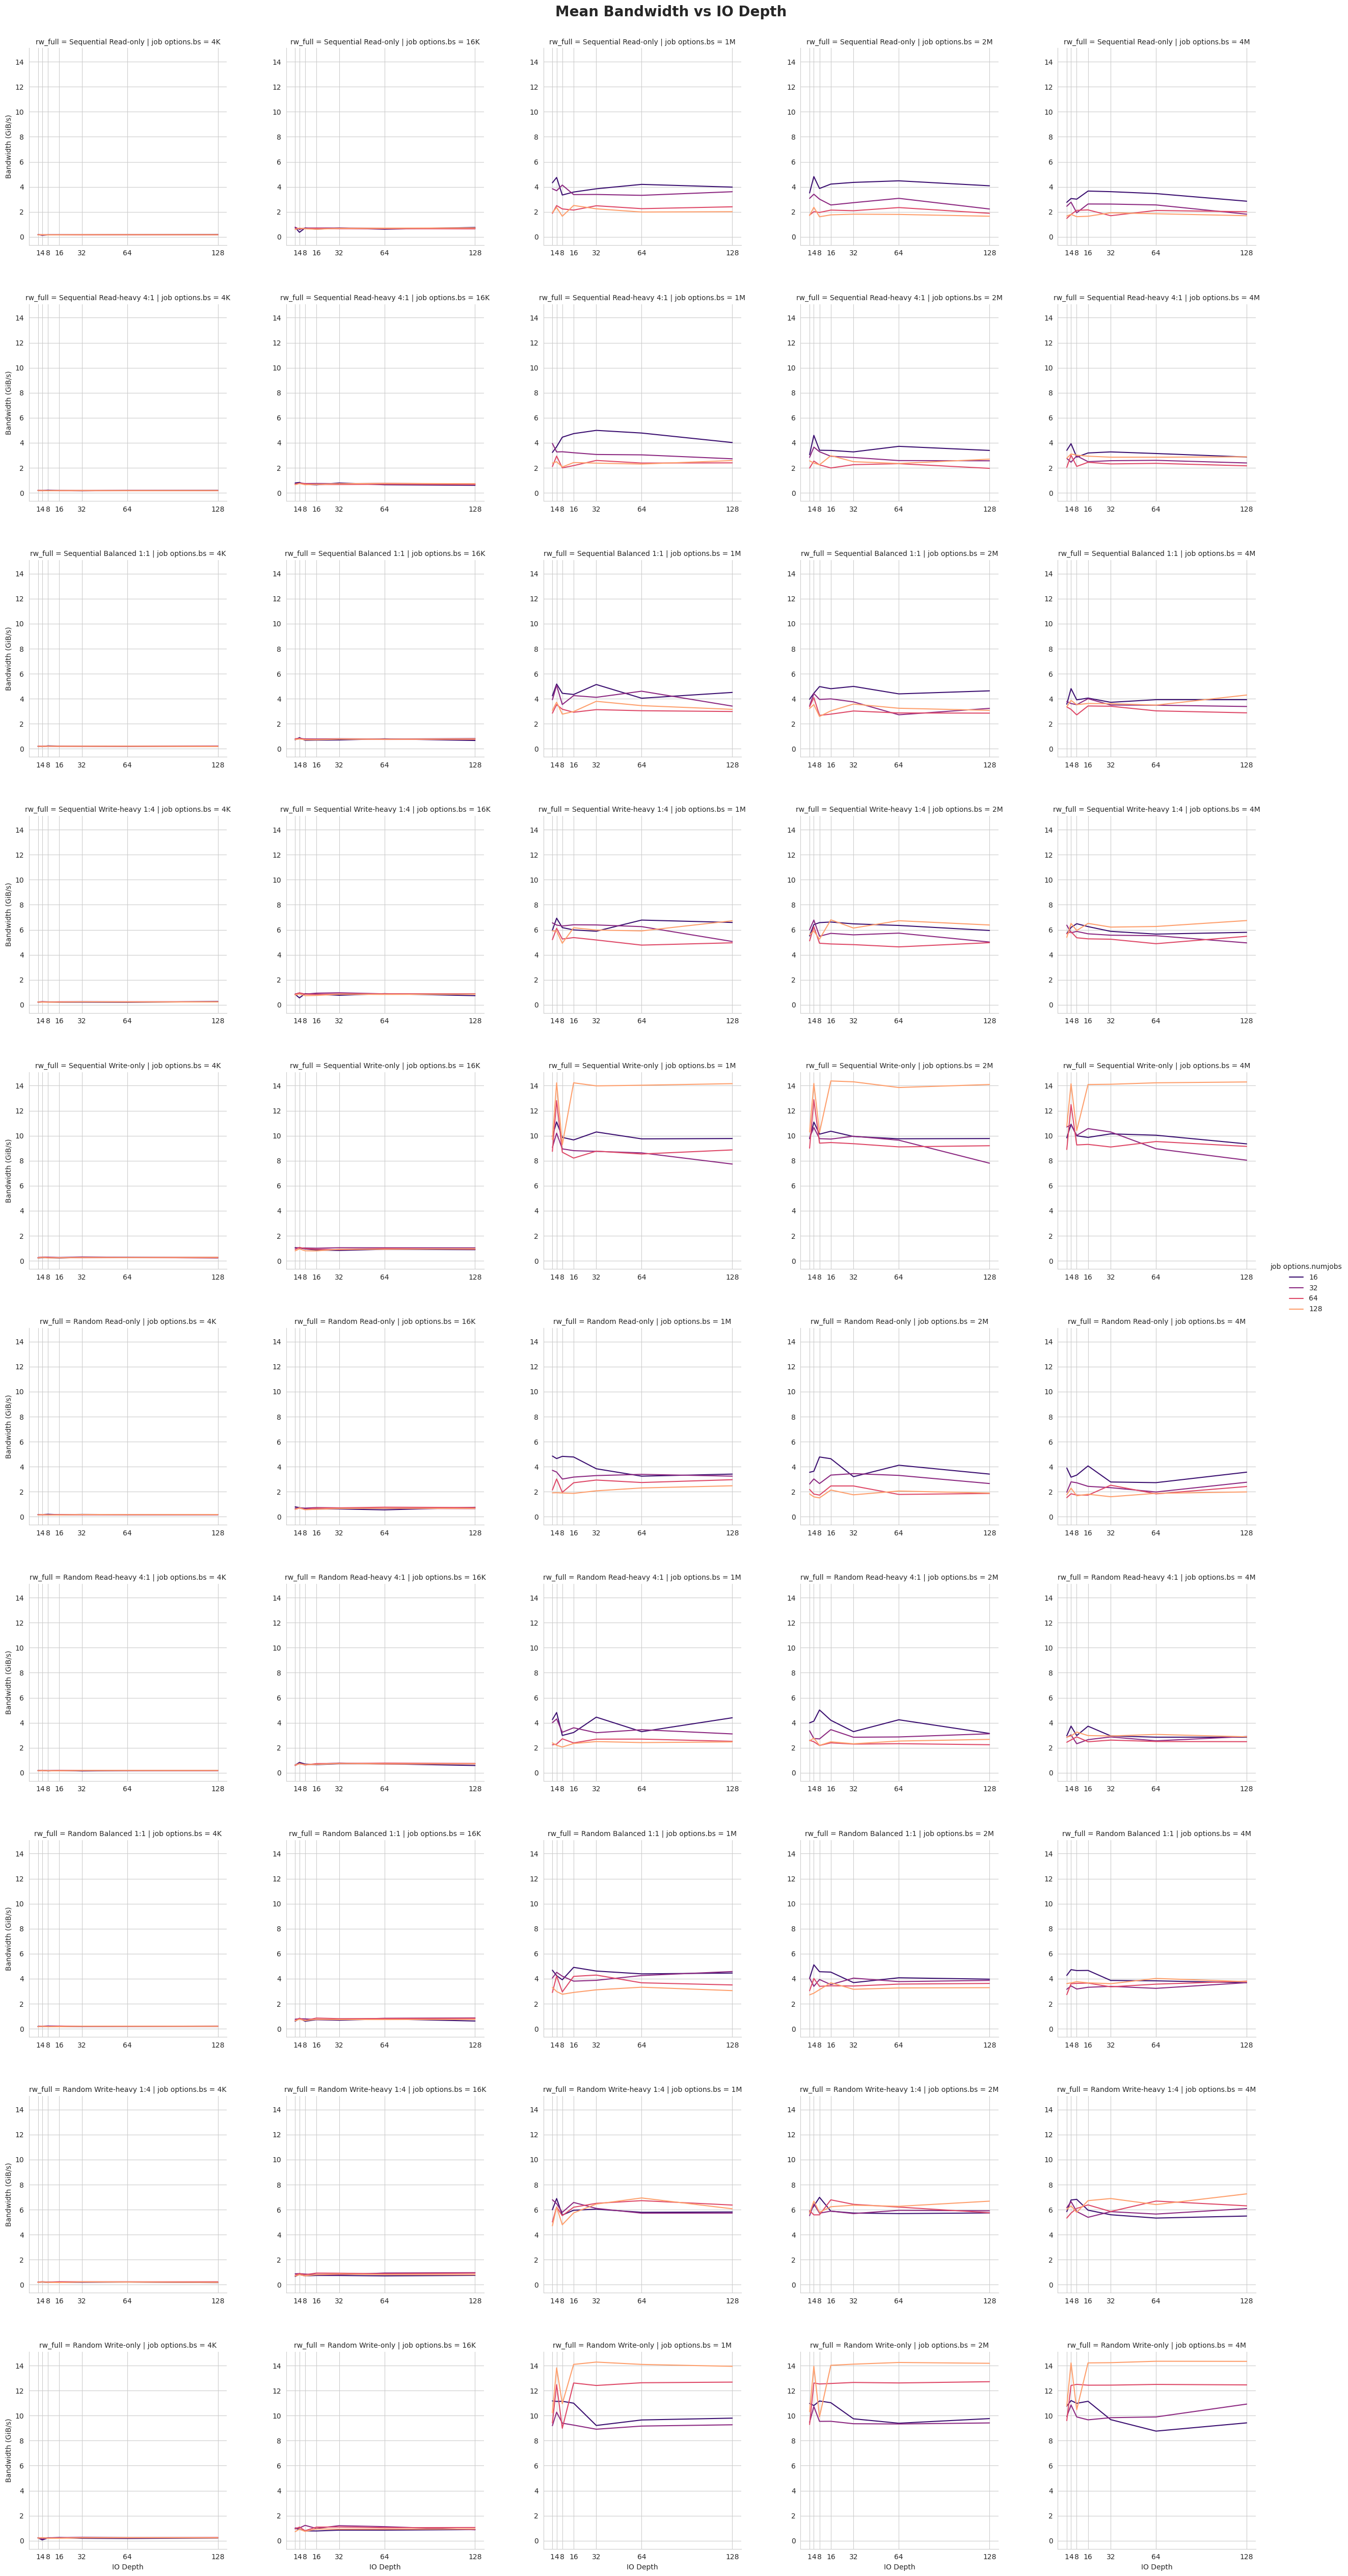

<Figure size 640x480 with 0 Axes>

In [108]:
# Y:    BANDWIDTH
# X:    IO DEPTH
# LINE: NUMBER OF JOBS

palette = sns.color_palette("magma", len(df['job options.numjobs'].unique()))

dashes = {'sequential': '', 'random': (5, 5) }

g = sns.relplot(data=df,
                kind="line",
                x="job options.iodepth",
                hue="job options.numjobs", 
                y="bw_mean",
                row="rw_full",
                col="job options.bs",
                palette=palette,
                row_order=hue_order,
                col_order=bs_order
                )
g.set_ylabels("Bandwidth (GiB/s)")
g.set_xlabels("IO Depth")
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
g.figure.suptitle("Mean Bandwidth vs IO Depth", fontsize=20, weight="bold", x = 0.5, y=1.01)
for i, ax in enumerate(g.axes.flat):
    ax.set_xticks(df["job options.iodepth"].unique())
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )


img_path = (png_dir + "/fio_bandwidth/fio_bw_vs_iod_hueNJ_allD.svg")
plt.savefig(img_path, bbox_inches="tight")
readme_images.append(img_path)
plt.show()
plt.clf()


### Individual Plots

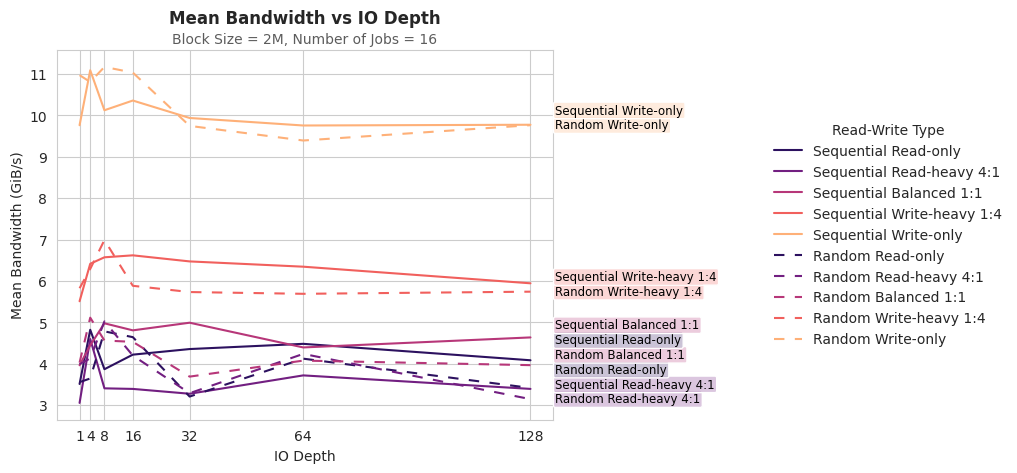

<Figure size 640x480 with 0 Axes>

In [109]:
# Y:    BANDWIDTH
# X:    IO DEPTH
# LINE: READ-WRITE TYPE

palette = sns.color_palette("magma", 5) + sns.color_palette("magma", 5)
for nj in df["job options.numjobs"].unique():
    for bs in df["job options.bs"].unique():
        subdf = df[ (df["job options.numjobs"] == nj) & (df["job options.bs"] == bs) ]
        dashes = {'sequential': '', 'random': (5, 5)}
        ax = sns.lineplot(
            data=subdf,
            x="job options.iodepth",
            y="bw_mean",
            hue="rw_full", 
            style="rand_seq_type", dashes=dashes,
            # marker='o',
            hue_order=hue_order,
            # order=bs_order,
            palette=palette
        )
        ax.set_xticks(subdf["job options.iodepth"].unique())
        ax.set_xlabel("IO Depth")
        ax.set_ylabel("Mean Bandwidth (GiB/s)")
        ax.set_title("Mean Bandwidth vs IO Depth", weight="bold", x=0.5, y=1.05)

        ax.text(x=0.5, y=1.01, 
                s=f"Block Size = {bs}, Number of Jobs = {nj}", 
                fontsize=10, alpha=0.75, ha='center', va='bottom', 
                transform=ax.transAxes)
        ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type', loc="upper left")

        # get lines and labels
        lines = ax.get_lines()
        lines = [l for l in lines if len(l.get_ydata())>0]

        handles, labels = ax.get_legend_handles_labels()
        labels = [label for label in labels if label in subdf['rw_full'].unique().tolist() ]

        end_points = sorted(
            [(h.get_ydata()[-1], h, l) for h, l in zip(lines, labels)],
            key=lambda tup: tup[0]
        )
        # set positions of labels
        y_positions = []
        min_gap = 0.04 * (ax.get_ylim()[1] - ax.get_ylim()[0]) 

        x_pos = 0
        y_pos = 0
        for line in lines:
            x_pos = max(x_pos, line.get_xdata()[-1] + 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0]))

        for i, (y, line, label) in enumerate(end_points):
            if i == 0:
                y_pos = y
            else:
                y_pos = max( y, y_positions[-1] + min_gap )
            # if i < 5:
            #     y_pos -= 0.1
            y_positions.append(y_pos)

            # highlighted lables
            stroke_color = mcolors.to_rgba(line.get_color(), alpha=0.25)
            ax.text(x_pos, y_pos, label, color='black',
                    bbox=dict( boxstyle='round,pad=0.15', facecolor=stroke_color),
                    va='center', fontsize=8.5)
            
        legend_x = x_pos + 0.4*(ax.get_xlim()[1] - ax.get_xlim()[0]) 
        legend_y = 0.5  

        ax.legend(
            loc='center left',
            labels=hue_order,
            handles=lines,
            bbox_to_anchor=(legend_x / ax.get_xlim()[1], legend_y),  
            title='Read-Write Type',
            frameon=False
        )

        # ax.legend_.remove()
        img_path = (png_dir + f"/fio_bandwidth/fio_bw_vs_iod_hueRW_nj-{nj}_bs-{bs}.svg")
        plt.savefig(img_path, bbox_inches="tight")
        if (bs==DISPLAY_BS and nj==DISPLAY_NJ):
            readme_images.append(img_path)
            plt.show()
        plt.clf()

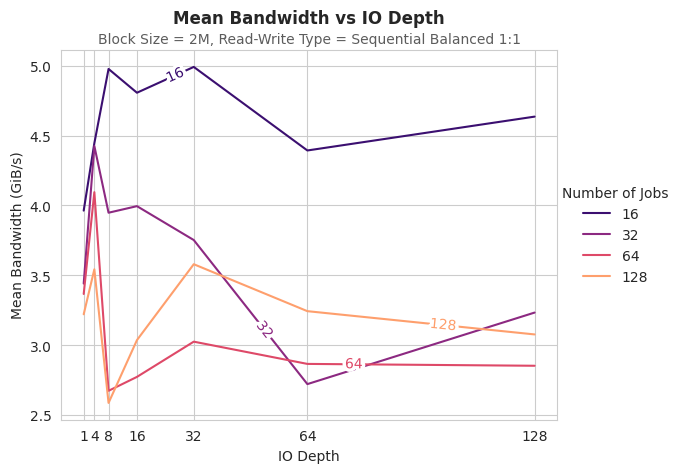

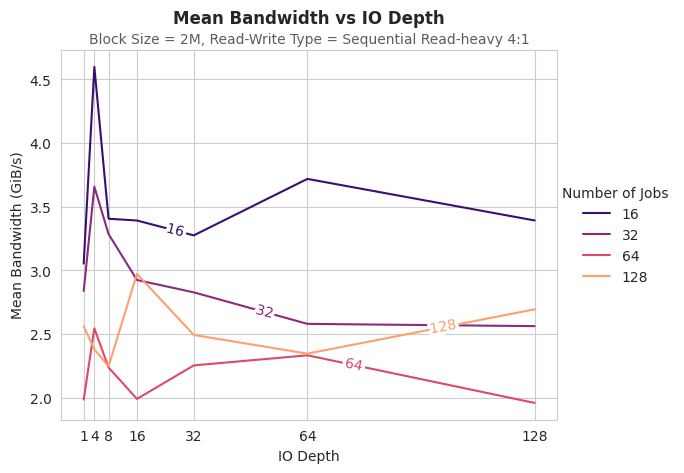

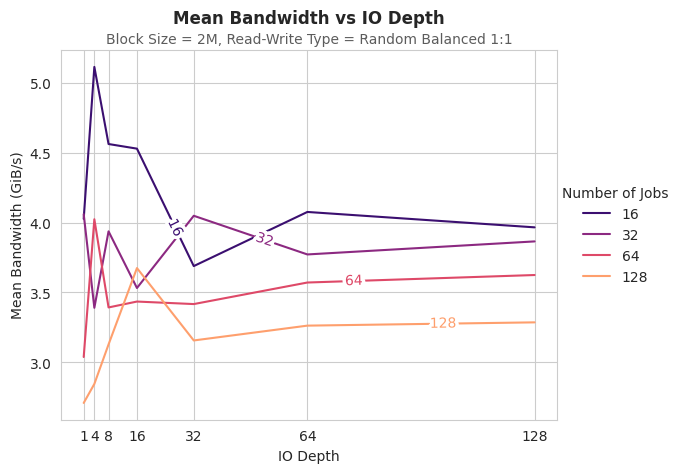

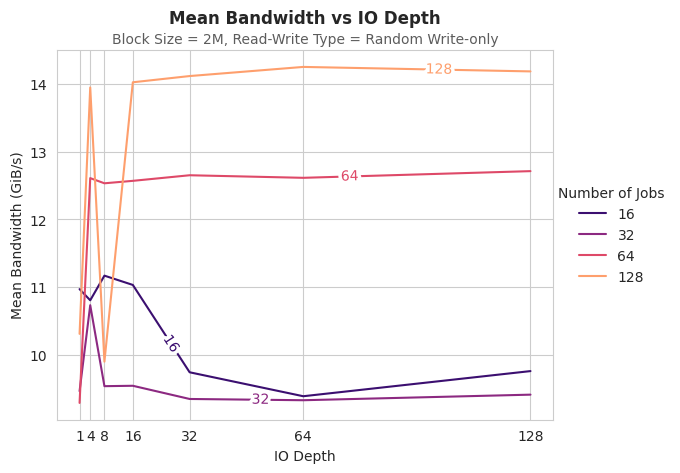

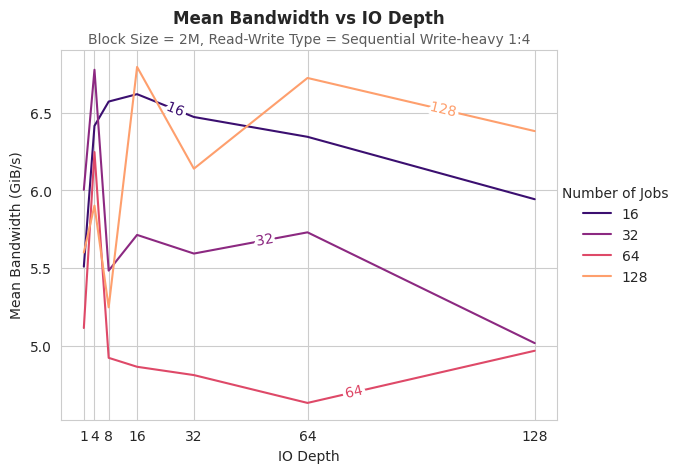

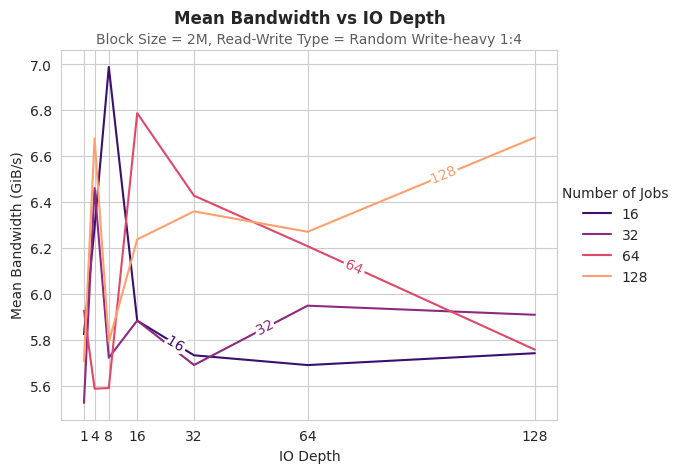

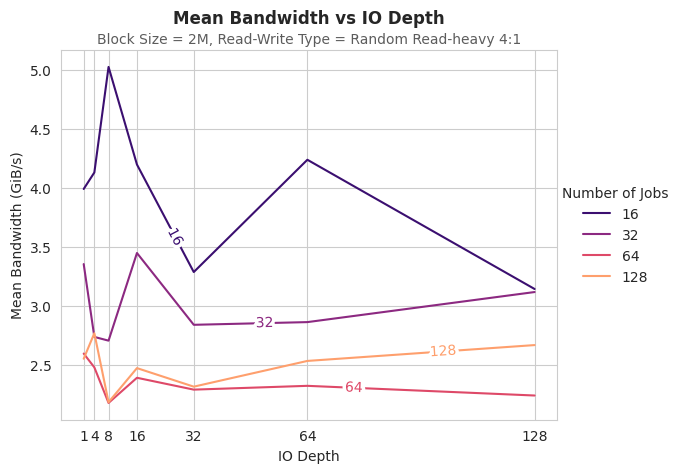

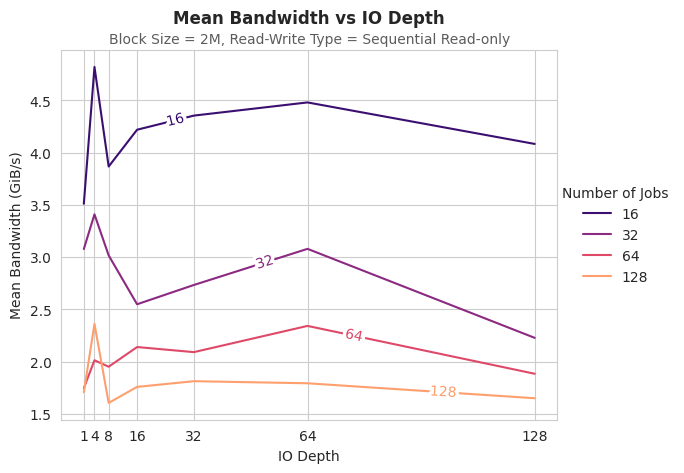

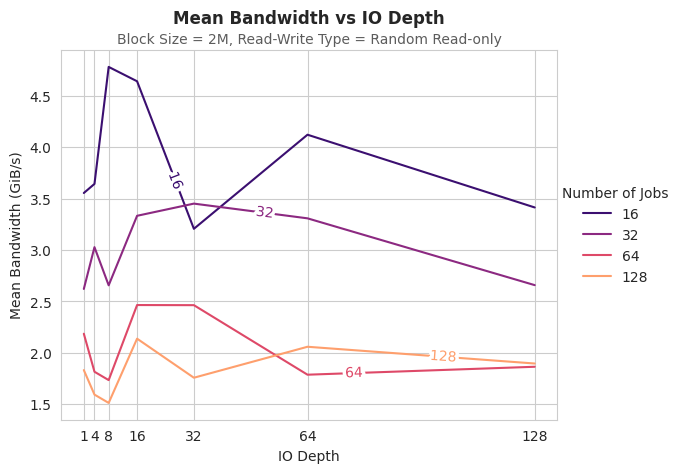

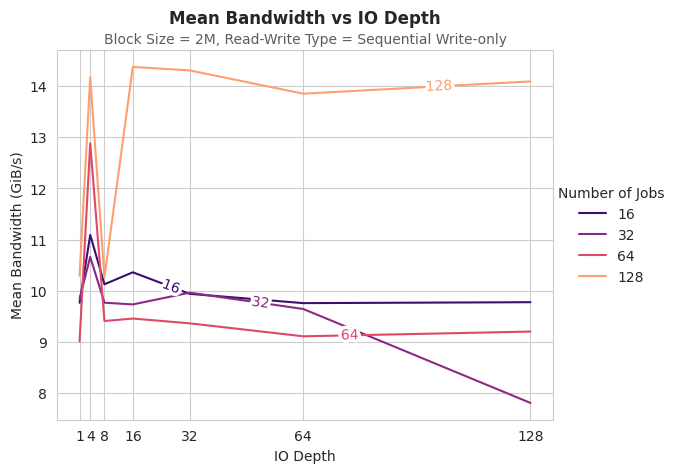

<Figure size 640x480 with 0 Axes>

In [110]:
# Y:    BANDWIDTH
# X:    IO DEPTH
# LINE: NUMBER OF JOBS
palette = sns.color_palette("magma", len(df['job options.numjobs'].unique()))
for rw in df["rw_full"].unique():
    for bs in df["job options.bs"].unique():
        subdf = df[ (df["rw_full"] == rw) & (df["job options.bs"] == bs) ]
        rows, cols = subdf.shape
        if rows >0:
            dashes = {
                'sequential': '',  # solid
                'random': (5, 5)  # dashed
            }
            ax = sns.lineplot(
                data=subdf,
                x="job options.iodepth",
                y="bw_mean",
                hue='job options.numjobs', 
                palette=palette
            )
            ax.set_xticks(subdf["job options.iodepth"].unique())
            ax.set_xlabel("IO Depth")
            ax.set_ylabel("Mean Bandwidth (GiB/s)")
            ax.set_title("Mean Bandwidth vs IO Depth", weight="bold", x=0.5, y=1.05)

            ax.text(x=0.5, y=1.01, 
                    s=f"Block Size = {bs}, Read-Write Type = {rw}", 
                    fontsize=10, alpha=0.75, ha='center', va='bottom', 
                    transform=ax.transAxes)

            lines = ax.get_lines()
            lines = [l for l in lines if len(l.get_ydata())>0]
            handles, labels = ax.get_legend_handles_labels()
            labels = [label for label in labels if label in str(subdf['job options.numjobs'].unique().tolist()) ]

            for line, label in zip(lines, labels):
                line.set_label(label)
        
            labelLines(lines)
            ax.legend(
                loc='center right',
                handles=lines,
                labels=labels,
                bbox_to_anchor=(1.25,.5),
                title='Number of Jobs',
                frameon=False
            )

            # ax.legend_.remove()
            rw_c = subdf.iloc[0]['rw_code']
            img_path = (png_dir + f"/fio_bandwidth/fio_bw_vs_iod_hueNJ_rw-{rw_c}_bs-{bs}.svg")
            plt.savefig(img_path, bbox_inches="tight")
            if (bs==DISPLAY_BS):
                readme_images.append(img_path)
                plt.show()
            plt.clf()

## Bandwidth vs Block Size

### Overview Grids

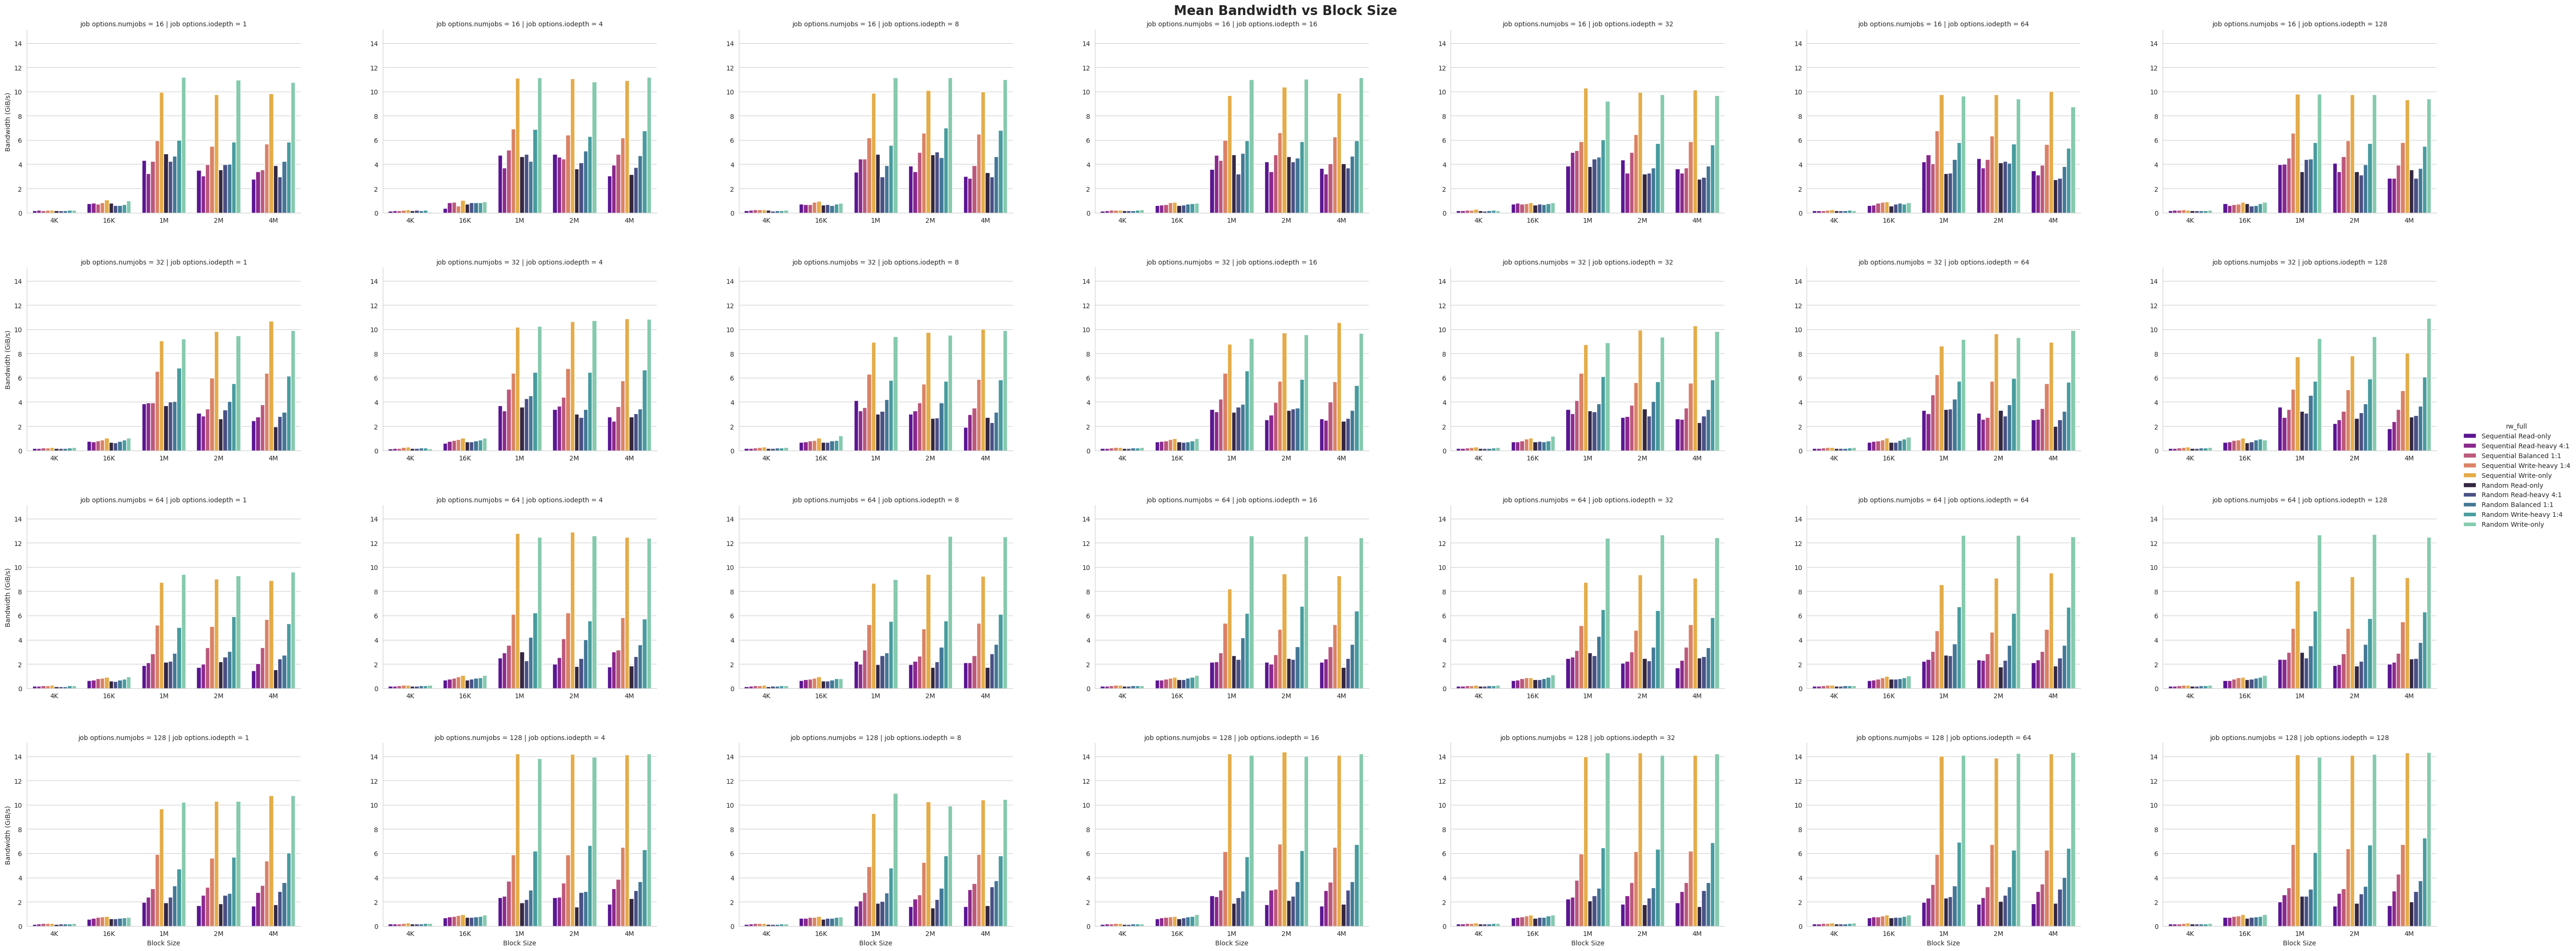

<Figure size 640x480 with 0 Axes>

In [111]:
# Y:    BANDWIDTH
# X:    BLOCK SIZE
# LINE: READ-WRITE TYPE
palette = sns.color_palette("plasma", 5) + sns.color_palette("mako", 5)
g = sns.catplot(data=df,
                kind="bar",
                x="job options.bs",
                hue="rw_full", 
                y="bw_mean",
                row="job options.numjobs",
                col="job options.iodepth",
                palette=palette,
                hue_order=hue_order,
                order=bs_order,
                errorbar=None,
                height=5, aspect=1.5,
                sharex=True, sharey=True
                )
# g.set_xticklabels(["4k", "16k", "1M", "2M", "4M"]) 
g.set_ylabels("Bandwidth (GiB/s)")
g.set_xlabels("Block Size")
g.figure.suptitle("Mean Bandwidth vs Block Size", fontsize=20, weight="bold", x = 0.5, y=1.01)
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(g.axes.flat):
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )

plt.savefig((png_dir + "/fio_bandwidth/fio_bw_vs_bs_allD.svg"), bbox_inches="tight")
readme_images.append(img_path)
plt.show()
plt.clf()

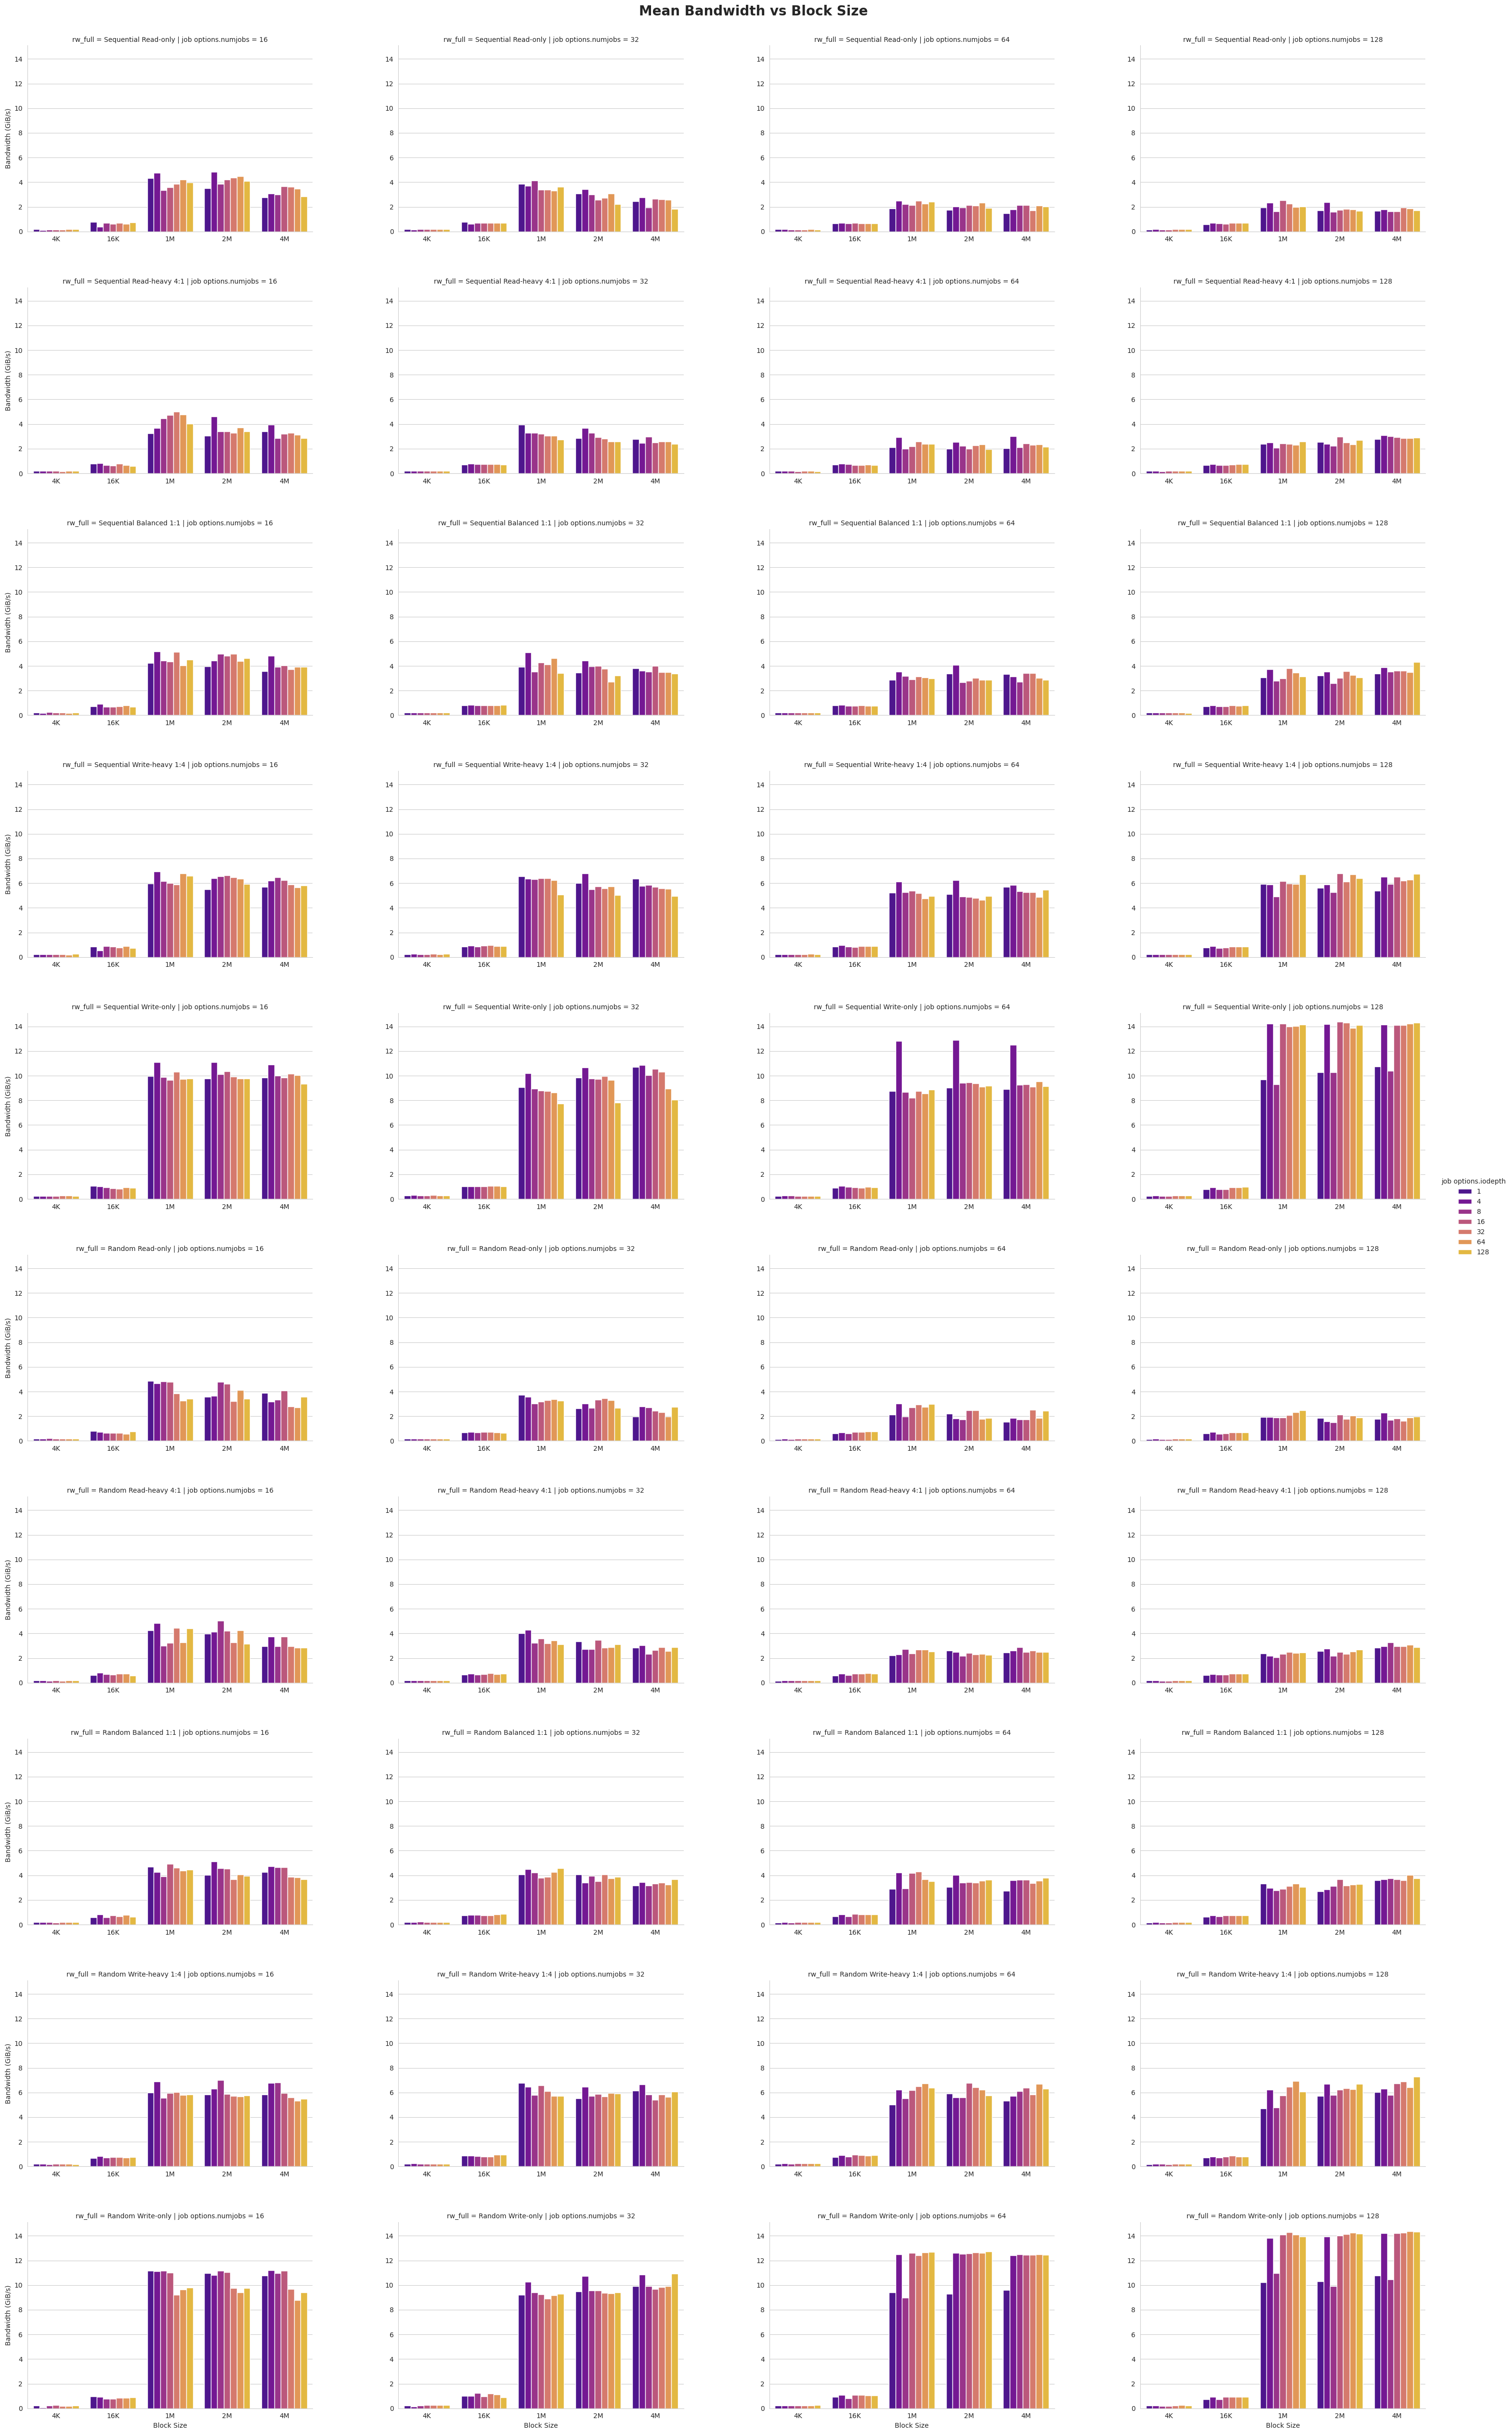

<Figure size 640x480 with 0 Axes>

In [112]:
# Y:    BANDWIDTH
# X:    BLOCK SIZE
# LINE: IO DEPTH
palette = sns.color_palette("plasma", len(df['job options.iodepth'].unique()))
g = sns.catplot(data=df,
                kind="bar",
                x="job options.bs",
                hue="job options.iodepth", 
                y="bw_mean",
                col="job options.numjobs",
                row="rw_full",
                palette=palette,
                row_order=hue_order,
                order=bs_order,
                errorbar=None,
                height=5, aspect=1.5,
                sharex=True, sharey=True
                )
# g.set_xticklabels(["4k", "16k", "1M", "2M", "4M"]) 
g.set_ylabels("Bandwidth (GiB/s)")
g.set_xlabels("Block Size")
g.figure.suptitle("Mean Bandwidth vs Block Size", fontsize=20, weight="bold", x = 0.5, y=1.01)
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(g.axes.flat):
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )

img_path = (png_dir + "/fio_bandwidth/fio_bw_vs_bs_allD.svg")
plt.savefig(img_path, bbox_inches="tight")
readme_images.append(img_path)
plt.show()
plt.clf()

### Individual Plots

/tmp/ipykernel_79464/2010362007.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(fig_width, 7))


<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

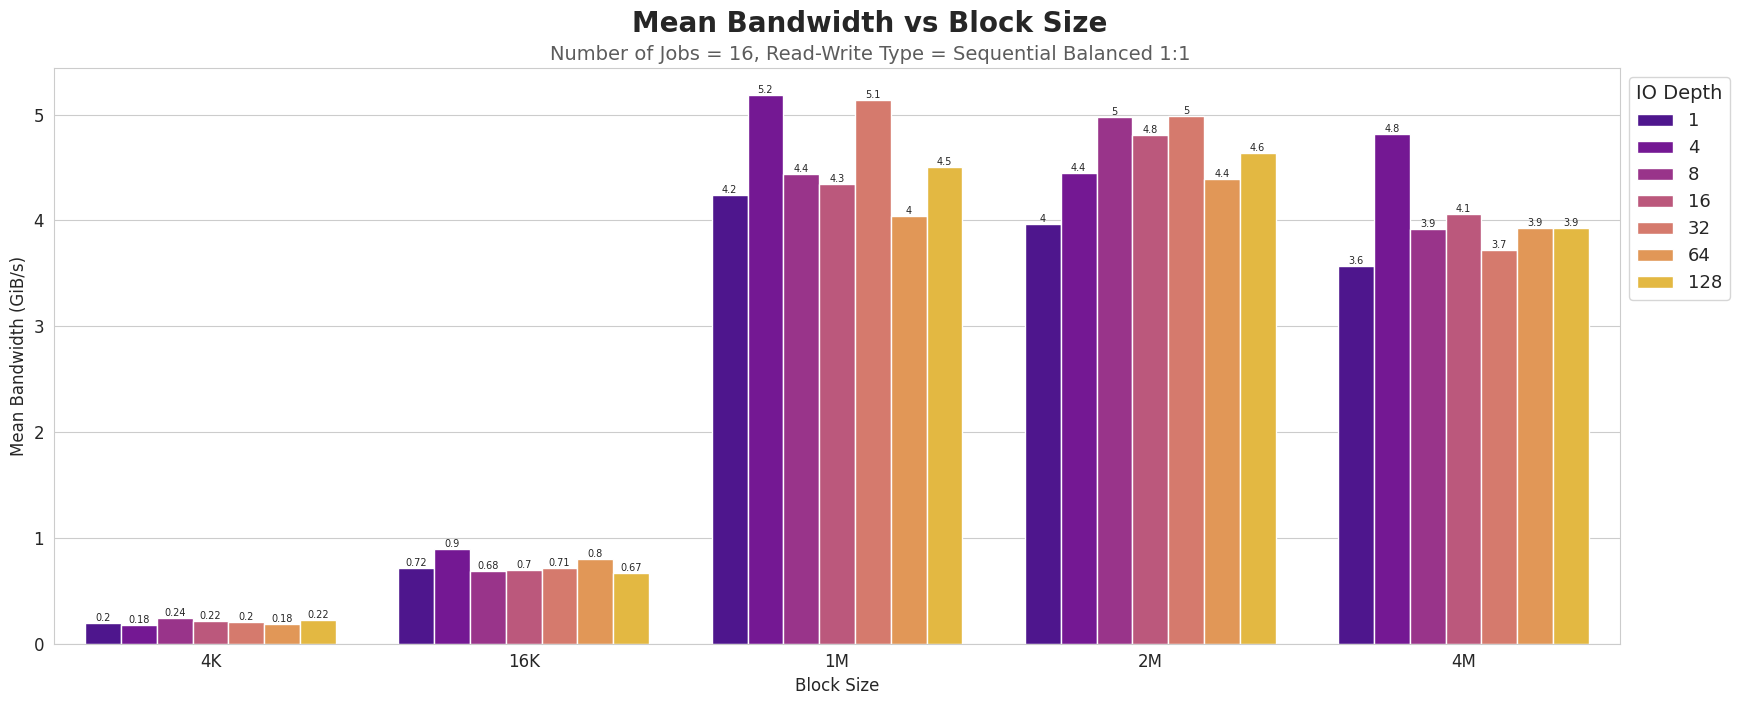

<Figure size 640x480 with 0 Axes>

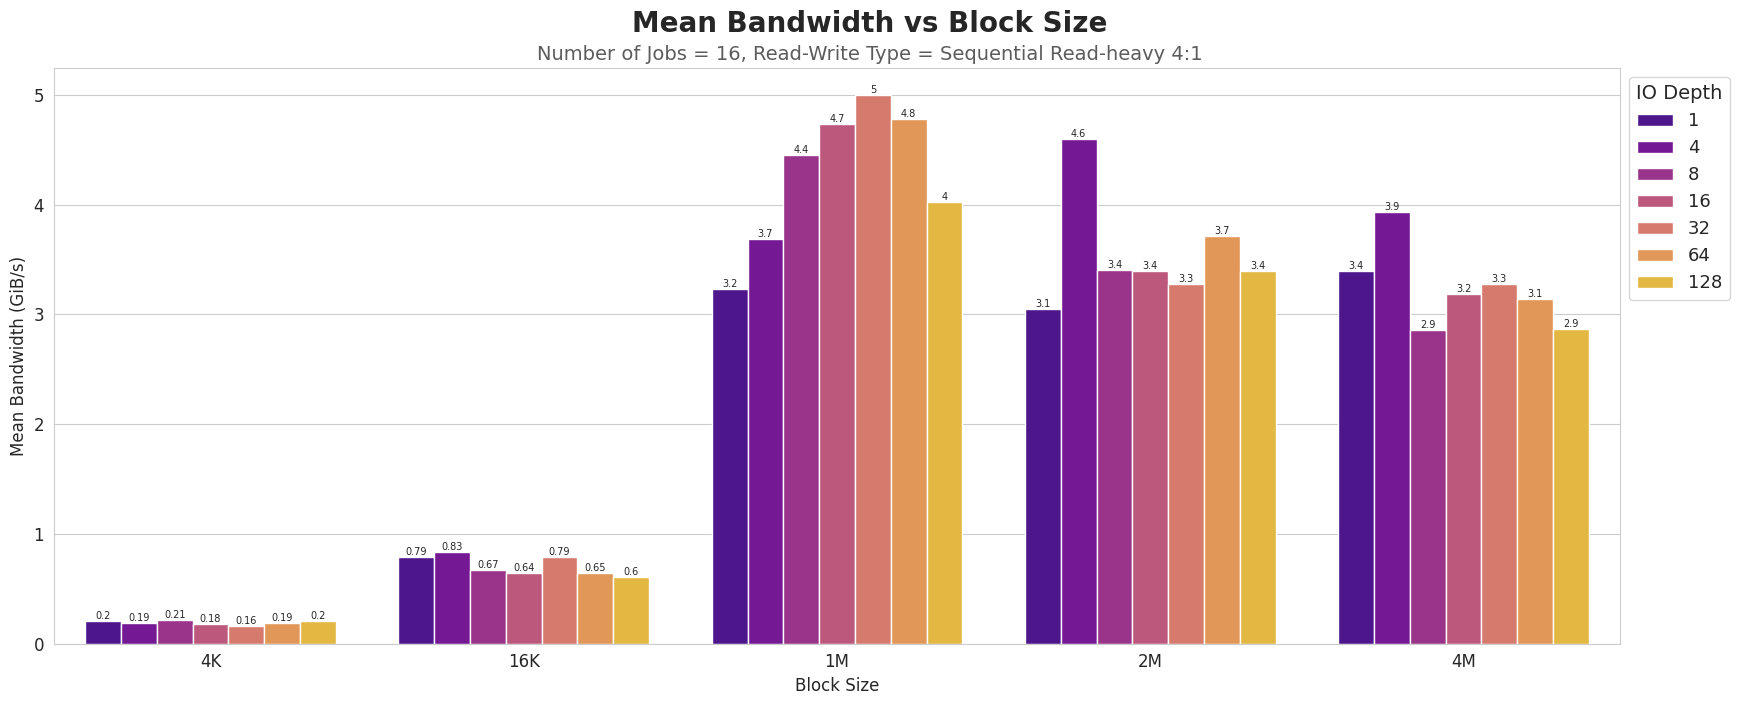

<Figure size 640x480 with 0 Axes>

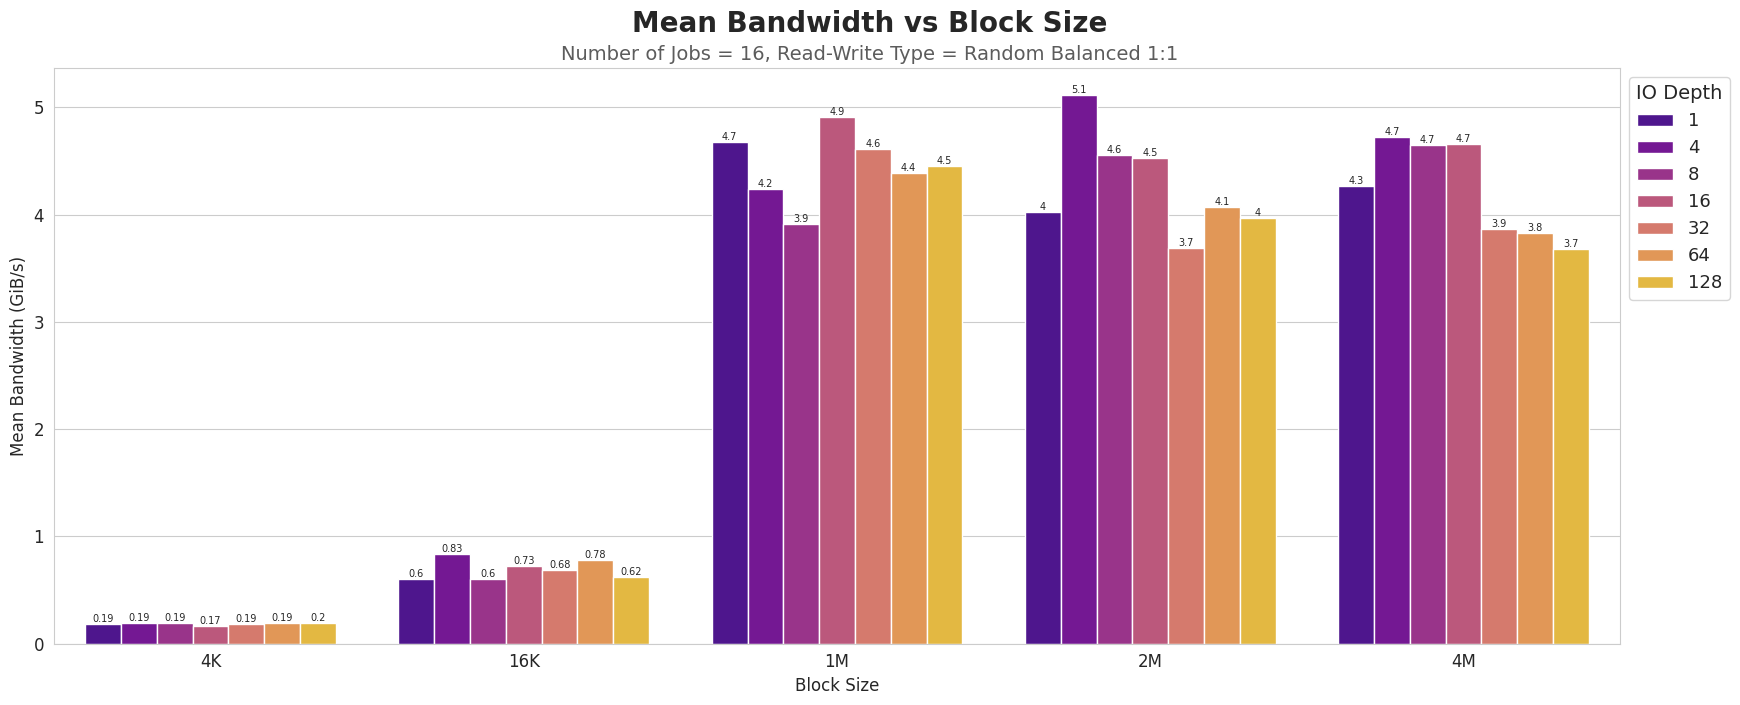

<Figure size 640x480 with 0 Axes>

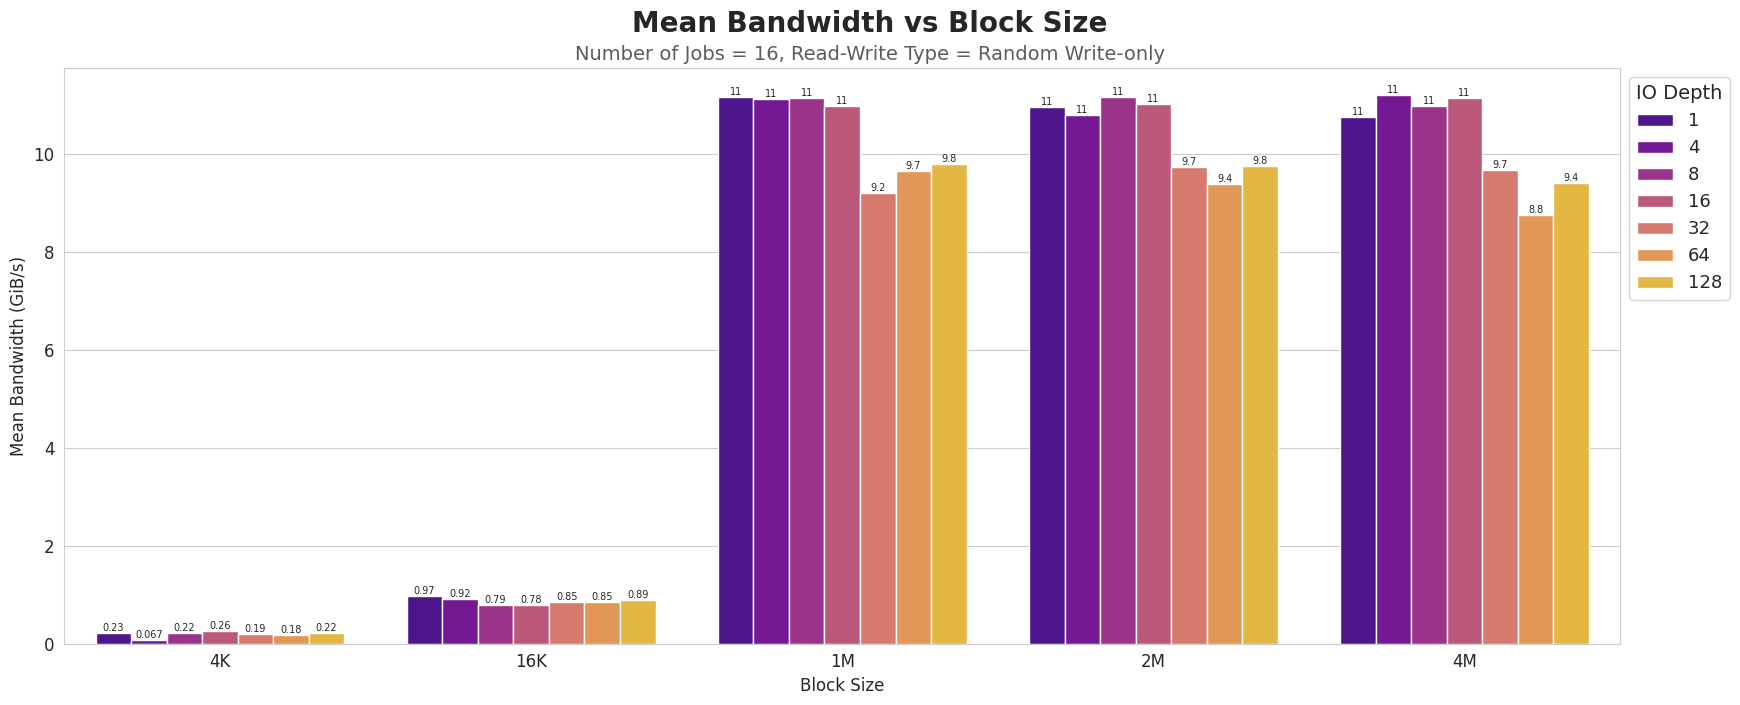

<Figure size 640x480 with 0 Axes>

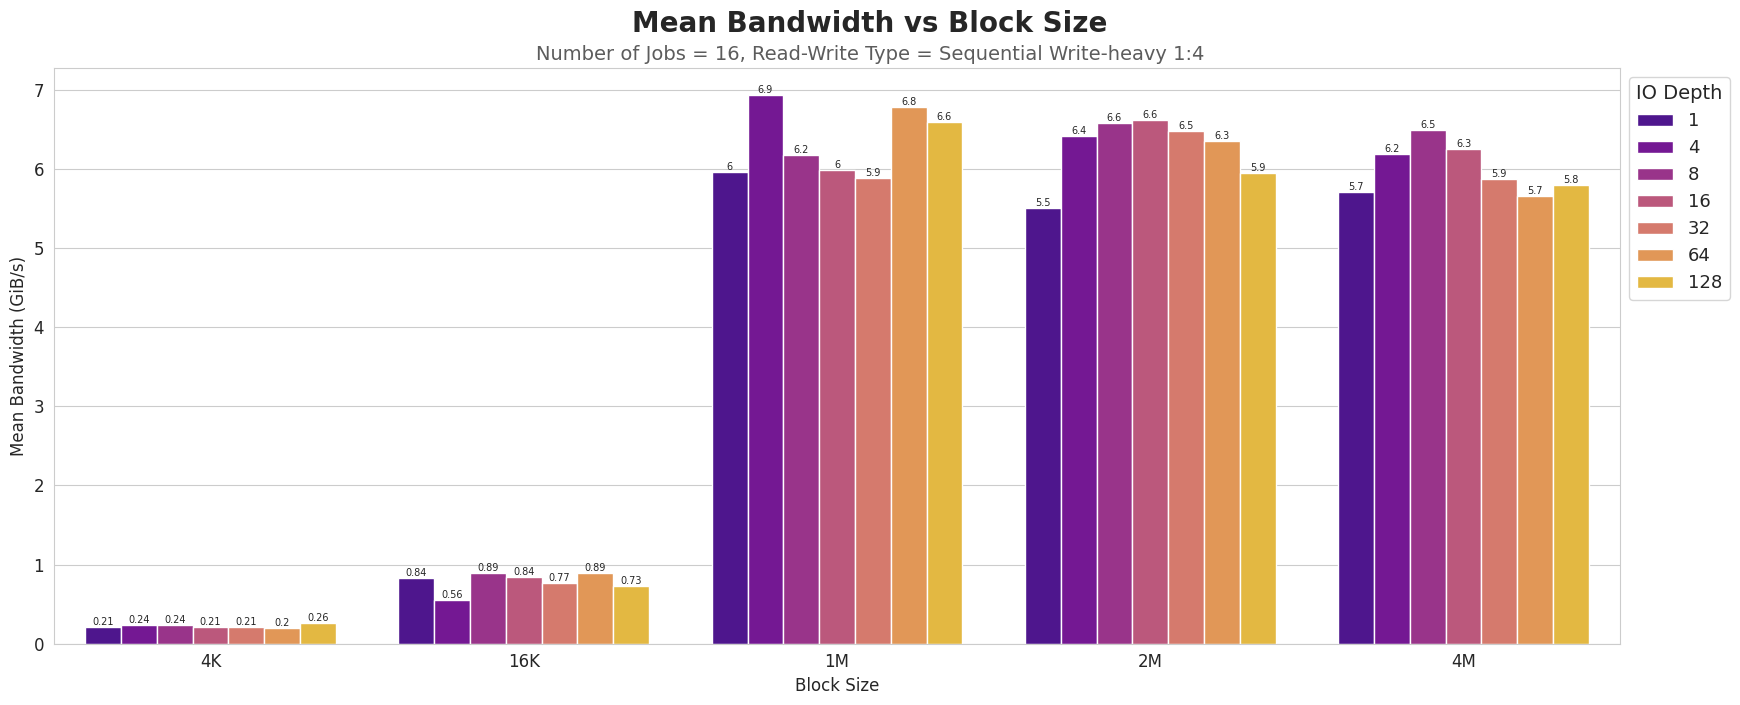

<Figure size 640x480 with 0 Axes>

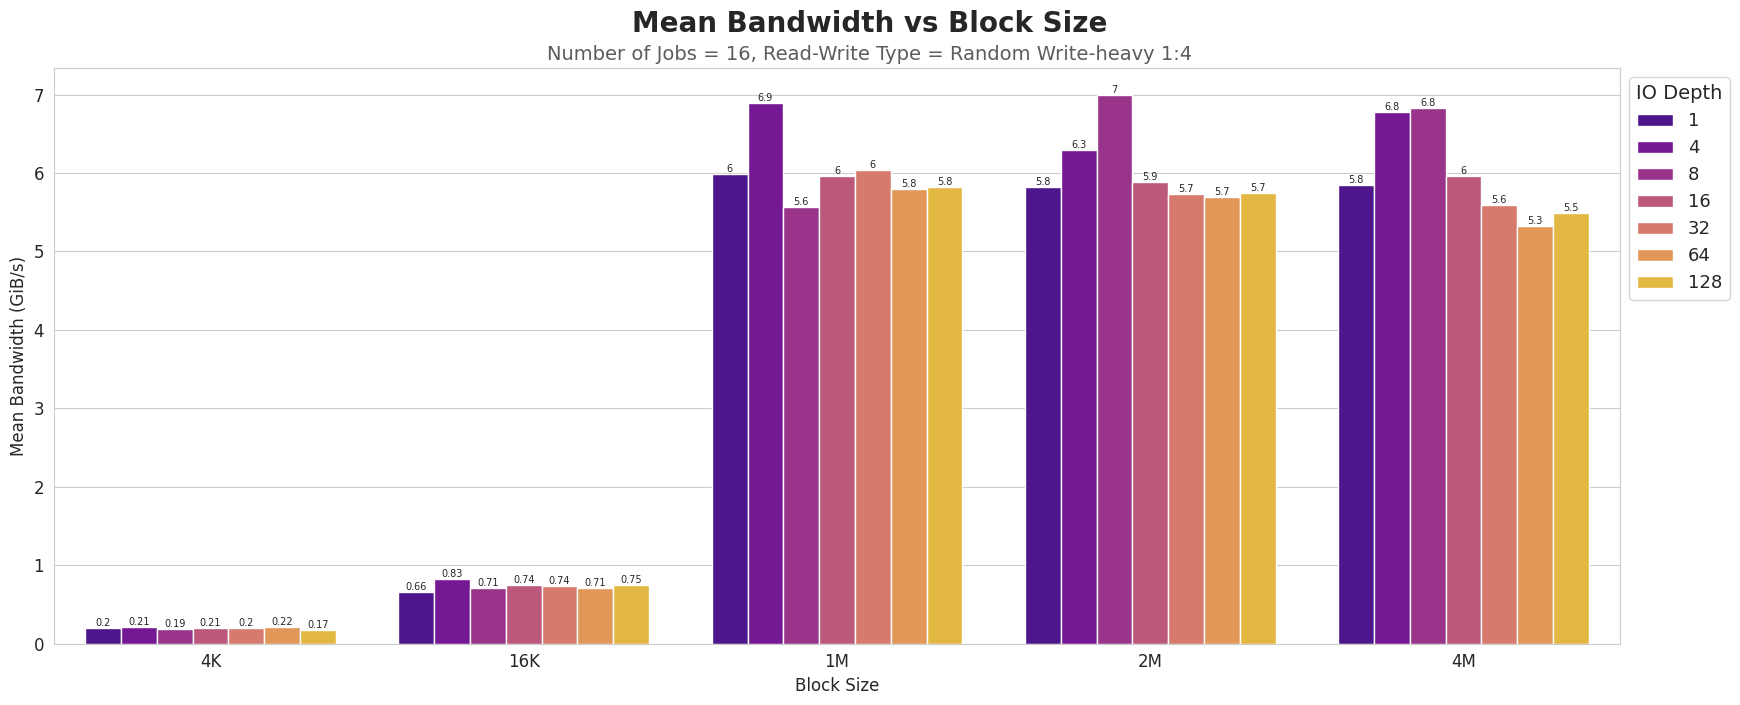

<Figure size 640x480 with 0 Axes>

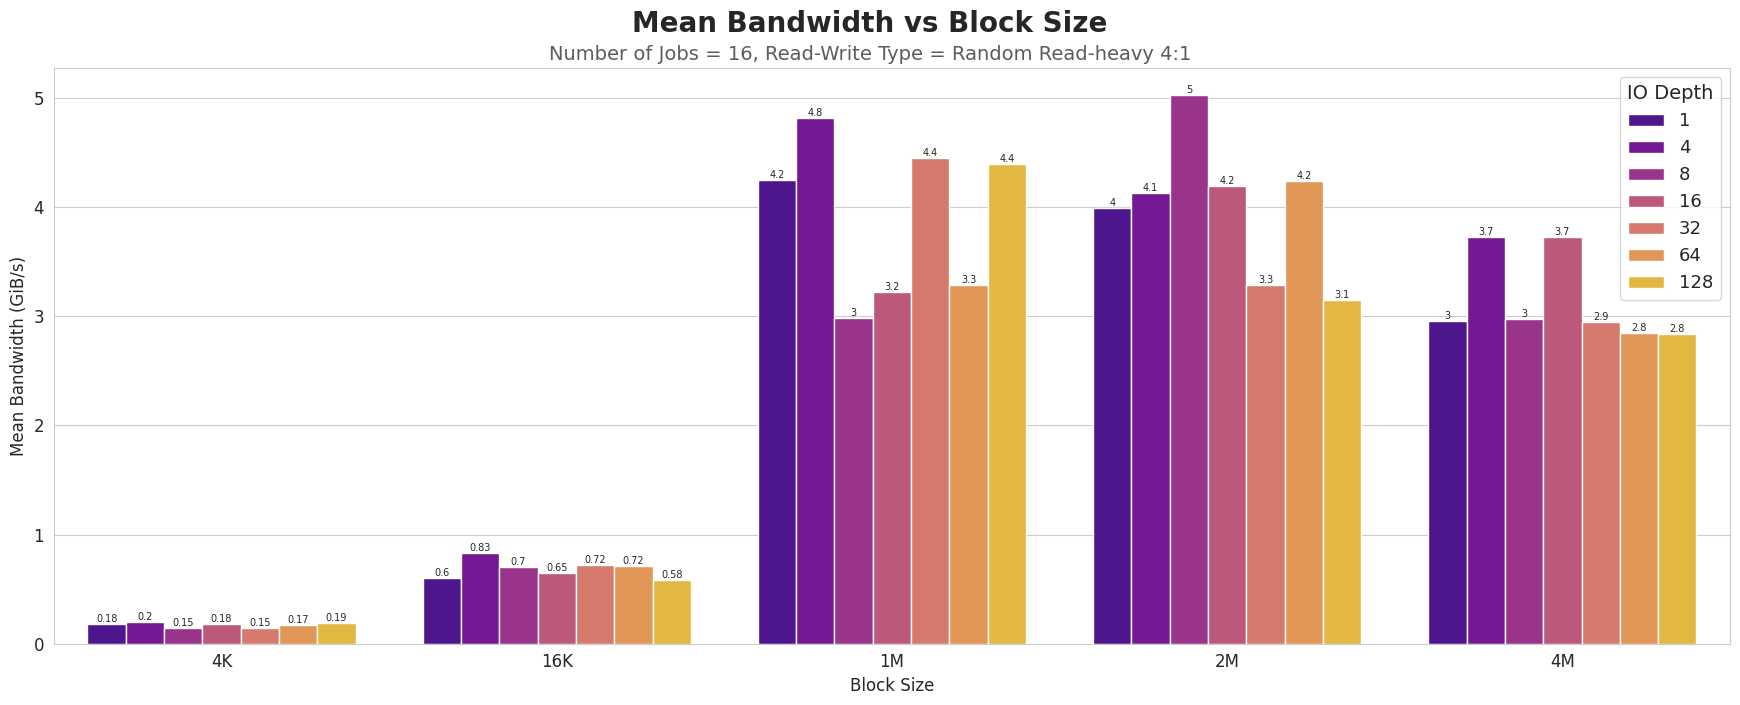

<Figure size 640x480 with 0 Axes>

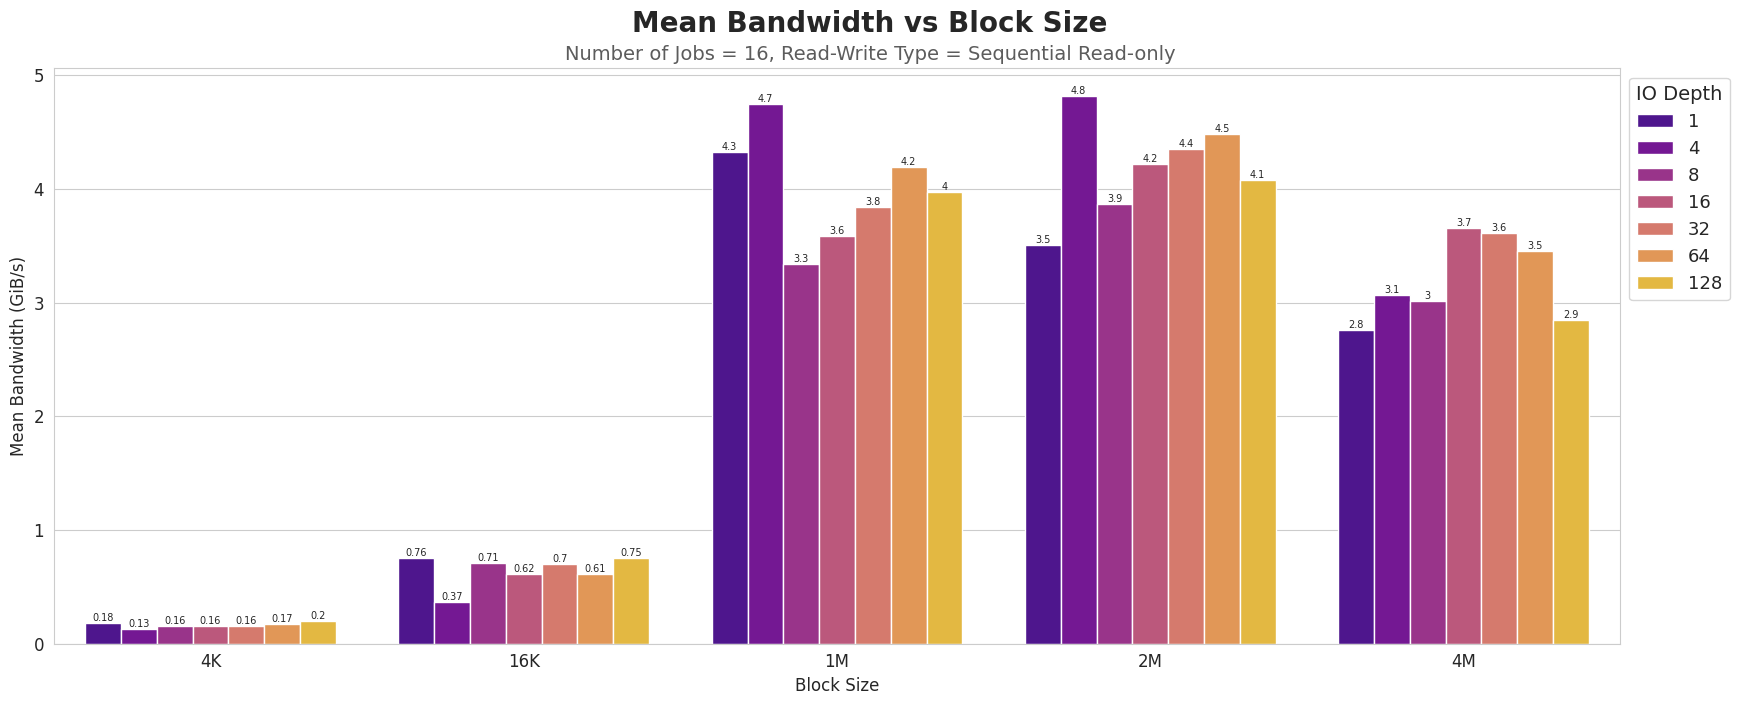

<Figure size 640x480 with 0 Axes>

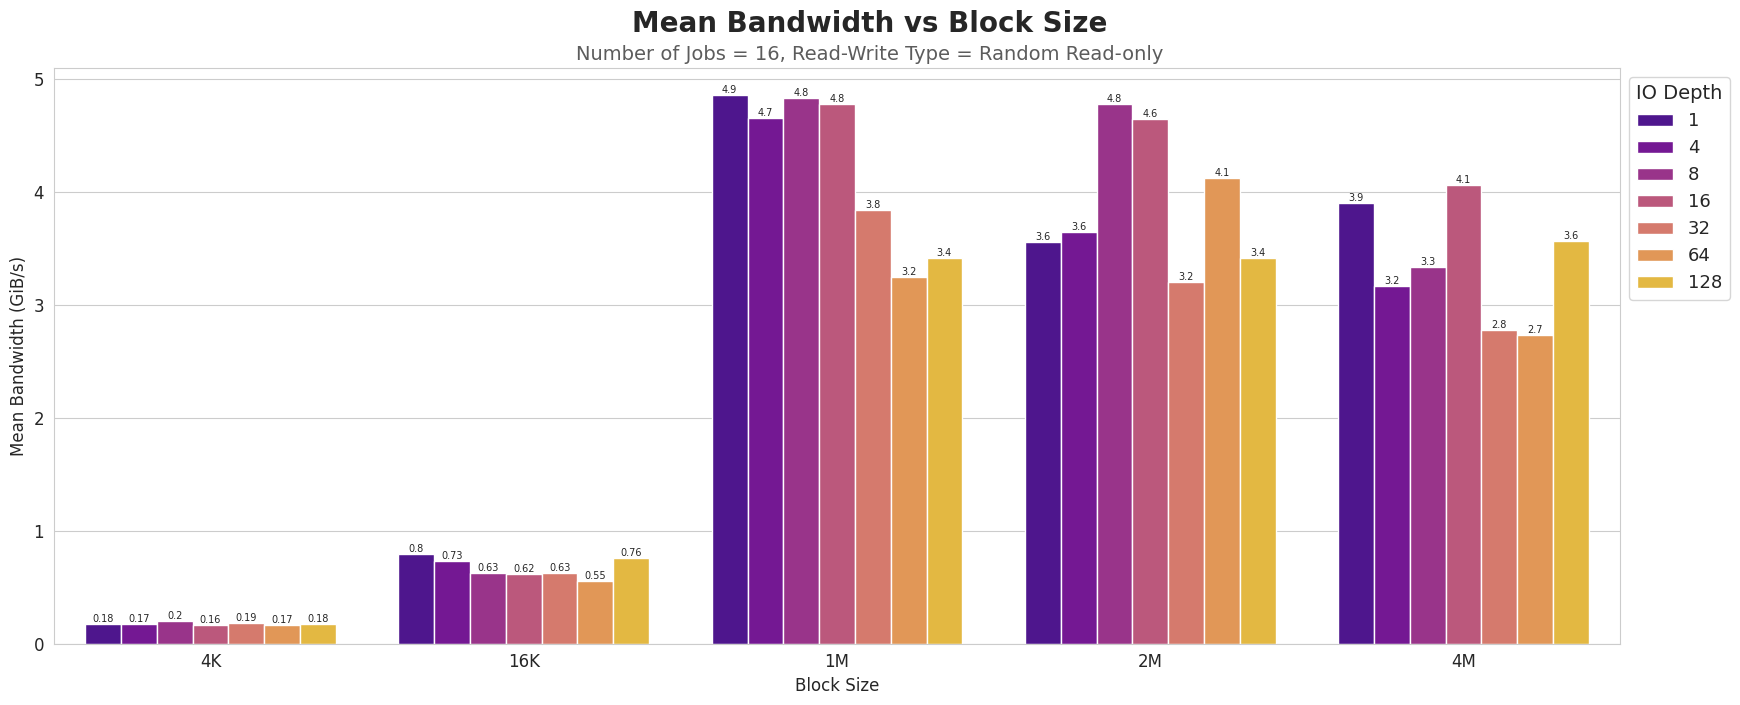

<Figure size 640x480 with 0 Axes>

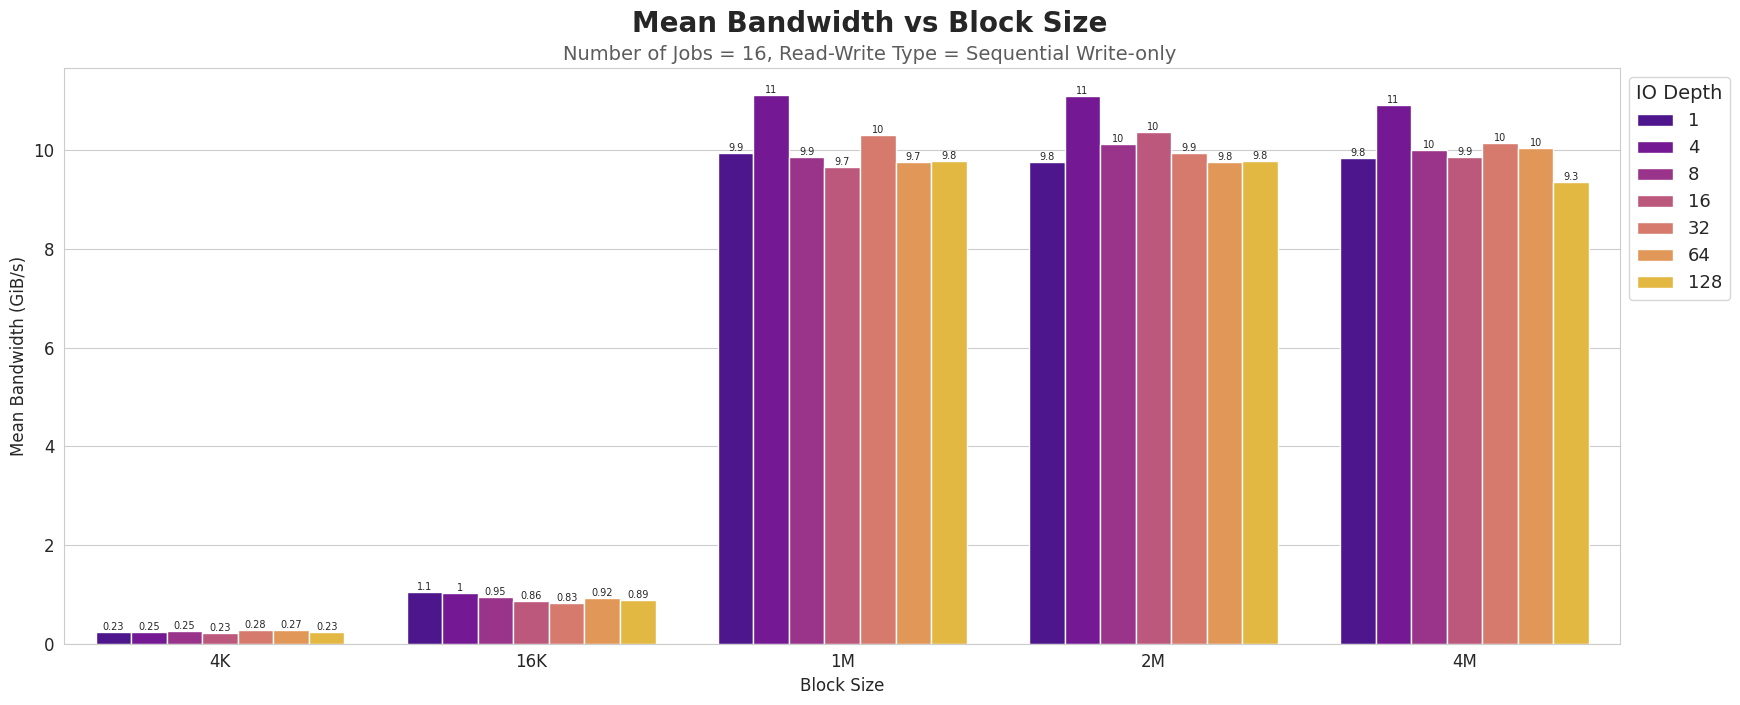

<Figure size 640x480 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

In [114]:
# Y:    BANDWIDTH
# X:    BLOCK SIZE
# LINE: IO DEPTH

palette = sns.color_palette("plasma", len(df['job options.iodepth'].unique()))

bar_width = 0.7
spacing = 0
fig_width = len(bs_order) * (5 * bar_width + spacing)

for nj in df["job options.numjobs"].unique():
    for rw_full in df["rw_full"].unique():
        subdf = df[ (df["job options.numjobs"] == nj) & (df["rw_full"] == rw_full) ]

        fig, ax = plt.subplots(figsize=(fig_width, 7))
        ax = sns.barplot(
            data=subdf,
            x="job options.bs",
            y="bw_mean",
            hue="job options.iodepth", 
            order=bs_order,
            palette=palette,
            errorbar=None
        )
        ax.set_xlabel("Block Size", fontsize=12)
        ax.set_ylabel("Mean Bandwidth (GiB/s)", fontsize=12)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        ax.legend(bbox_to_anchor=(1, 1), title='IO Depth', fontsize=13, title_fontsize=14)
        fig.suptitle("Mean Bandwidth vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, Read-Write Type = {rw_full}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        fig.tight_layout()
        for container in ax.containers:
            ax.bar_label(container, 
                            labels=[f"{v:.2g}" for v in container.datavalues], 
                            fontsize=7)
        
        rw_c = subdf.iloc[0]['rw_code']
        img_path = (png_dir + f"/fio_bandwidth/fio_bw_vs_bs_rw-{rw_c}_iod-{iod}.svg")
        plt.savefig(img_path, bbox_inches="tight")
        if (nj==DISPLAY_NJ):
            readme_images.append(img_path)
            plt.show()
        plt.clf()

In [ ]:
# Y:    BANDWIDTH
# X:    BLOCK SIZE
# LINE: READ-WRITE TYPE

palette = sns.color_palette("plasma", 5) + sns.color_palette("mako", 5)

bar_width = 0.7
spacing = 0
fig_width = len(bs_order) * (5 * bar_width + spacing)


for nj in df["job options.numjobs"].unique():
    for iod in df["job options.iodepth"].unique():
        subdf = df[ (df["job options.numjobs"] == nj) & (df["job options.iodepth"] == iod) ]

        # nj = subdf['job options.numjobs'].iloc[0]
        # iod = subdf['job options.iodepth'].iloc[0]

        # FULL
        fig, ax = plt.subplots(figsize=(fig_width, 7))
        ax = sns.barplot(
            data=subdf,
            x="job options.bs",
            y="bw_mean",
            hue="rw_full", 
            hue_order=hue_order,
            order=bs_order,
            palette=palette,
            errorbar=None
        )
        ax.set_xlabel("Block Size", fontsize=12)
        ax.set_ylabel("Mean Bandwidth (GiB/s)", fontsize=12)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type', fontsize=13, title_fontsize=14)
        fig.suptitle("Mean Bandwidth vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        fig.tight_layout()
        for container in ax.containers:
            ax.bar_label(container, 
                            labels=[f"{v:.2g}" for v in container.datavalues], 
                            fontsize=7)
        
        img_path = (png_dir + f"/fio_bandwidth/fio_bw_vs_bs_hueRW_nj-{nj}_iod-{iod}.svg")
        plt.savefig(img_path, bbox_inches="tight")
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            readme_images.append(img_path)
            plt.show()
        plt.clf()

        

        # SEQUENTIAL and RANDOM side by side
        fig, axes = plt.subplots(1,2, sharey=True, figsize=(fig_width,7))
        subdf_s = subdf[subdf['rw_full'].isin(sequential_full)]
        sns.barplot(
            data=subdf_s,
            x="job options.bs",
            y="bw_mean",
            hue="rw_full", 
            hue_order=sequential_full,
            order=bs_order,
            palette=palette[:5],
            errorbar=None, 
            dodge=True,
            ax=axes[0]
        )
        axes[0].set_xlabel("Block Size", fontsize=12)
        axes[0].set_ylabel("Mean Bandwidth (GiB/s)", fontsize=12)
        axes[0].set_title("Sequential")
        # RANDOM
        subdf_r = subdf[subdf['rw_full'].isin(random_full)]
        sns.barplot(
            data=subdf_r,
            x="job options.bs",
            y="bw_mean",
            hue="rw_full", 
            hue_order=random_full,
            order=bs_order,
            palette=palette[5:],
            errorbar=None,
            dodge=True,
            ax=axes[1]
        )
        axes[1].set_xlabel("Block Size", fontsize=12)
        axes[1].set_ylabel("Mean Bandwidth (GiB/s)", fontsize=12)
        axes[1].set_title("Random")

        for ax in axes:
            ax.tick_params(labelbottom=True, labelleft=True)
            ax.tick_params(axis="x", labelsize=12)
            ax.tick_params(axis="y", labelsize=12)
            for container in ax.containers:
                ax.bar_label(container, 
                            labels=[f"{v:.2g}" for v in container.datavalues], 
                            fontsize=7)

        handles_labels = [ax.get_legend_handles_labels() for ax in axes]
        handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
        fig.legend(handles, labels, bbox_to_anchor=(1, 1), title='Read-Write Type', loc="upper left",fontsize=13, title_fontsize=14)
        if (axes[0].legend_ is not None):
            axes[0].legend_.remove()
        if(axes[1].legend_ is not None):
            axes[1].legend_.remove()

        fig.suptitle("Mean Bandwidth vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        fig.tight_layout()

        img_path = (png_dir + f"/fio_bandwidth/fio_bw_vs_bs_hueRW_SR_nj-{nj}_iod-{iod}.svg")
        plt.savefig(img_path, bbox_inches="tight")
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            readme_images.append(img_path)
            plt.show()
        plt.clf()

# IOPS Plots

In [ ]:
# Y:    IOPS
# X:    BLOCK SIZE
# LINE: READ-WRITE TYPE

palette = sns.color_palette("plasma", 5) + sns.color_palette("mako", 5)

bar_width = 0.7
spacing = 0
fig_width = len(bs_order) * (5 * bar_width + spacing)


for nj in df["job options.numjobs"].unique():
    for iod in df["job options.iodepth"].unique():
        subdf = df[ (df["job options.numjobs"] == nj) & (df["job options.iodepth"] == iod) ]

        # FULL
        fig, ax = plt.subplots(figsize=(fig_width, 7))
        ax = sns.barplot(
            data=subdf,
            x="job options.bs",
            y="iops",
            hue="rw_full", 
            hue_order=hue_order,
            order=bs_order,
            palette=palette,
            errorbar=None
        )
        ax.set_xlabel("Block Size", fontsize=12)
        ax.set_ylabel("IOPS", fontsize=12)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type', fontsize=13, title_fontsize=14)
        fig.suptitle("Mean Bandwidth vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        fig.tight_layout()
        # for container in ax.containers:
        #     ax.bar_label(container, 
        #                     labels=[f"{v:.2g}" for v in container.datavalues], 
        #                     fontsize=7)
        img_path = (png_dir + f"/fio_iops/fio_iops_vs_bs_nj-{nj}_iod-{iod}.svg")
        plt.savefig(img_path, bbox_inches="tight")
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            readme_images.append(img_path)
            plt.show()
        plt.clf()

        

        # SEQUENTIAL and RANDOM side by side
        fig, axes = plt.subplots(1,2, sharey=True, figsize=(fig_width,7))
        subdf_s = subdf[subdf['rw_full'].isin(sequential_full)]
        sns.barplot(
            data=subdf_s,
            x="job options.bs",
            y="iops",
            hue="rw_full", 
            hue_order=sequential_full,
            order=bs_order,
            palette=palette[:5],
            errorbar=None, 
            dodge=True,
            ax=axes[0]
        )
        axes[0].set_xlabel("Block Size", fontsize=12)
        axes[0].set_ylabel("IOPS", fontsize=12)
        axes[0].set_title("Sequential")
        # RANDOM
        subdf_r = subdf[subdf['rw_full'].isin(random_full)]
        sns.barplot(
            data=subdf_r,
            x="job options.bs",
            y="iops",
            hue="rw_full", 
            hue_order=random_full,
            order=bs_order,
            palette=palette[5:],
            errorbar=None,
            dodge=True,
            ax=axes[1]
        )
        axes[1].set_xlabel("Block Size", fontsize=12)
        axes[1].set_ylabel("IOPS", fontsize=12)
        axes[1].set_title("Random")

        for ax in axes:
            ax.tick_params(labelbottom=True, labelleft=True)
            ax.tick_params(axis="x", labelsize=12)
            ax.tick_params(axis="y", labelsize=12)
            # for container in ax.containers:
            #     ax.bar_label(container, 
            #                 labels=[f"{v:.2g}" for v in container.datavalues], 
            #                 fontsize=7)

        handles_labels = [ax.get_legend_handles_labels() for ax in axes]
        handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
        fig.legend(handles, labels, bbox_to_anchor=(1, 1), title='Read-Write Type', loc="upper left",fontsize=13, title_fontsize=14)
        if (axes[0].legend_ is not None):
            axes[0].legend_.remove()
        if(axes[1].legend_ is not None):
            axes[1].legend_.remove()

        fig.suptitle("Mean Bandwidth vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        # fig.tight_layout()
        img_path = (png_dir + f"/fio_iops/fio_iops_vs_bs_SR_nj-{nj}_iod-{iod}.svg")
        plt.savefig(img_path, bbox_inches="tight")
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            plt.show()
            readme_images.append(img_path)
        plt.clf()

# Latency Plots

In [ ]:
palette = sns.color_palette("plasma", 5) + sns.color_palette("mako", 5)

bar_width = 0.7
spacing = 0
fig_width = len(bs_order) * (5 * bar_width + spacing)


for nj in df["job options.numjobs"].unique():
    for iod in df["job options.iodepth"].unique():
        subdf = df[ (df["job options.numjobs"] == nj) & (df["job options.iodepth"] == iod) ]

        # FULL
        fig, ax = plt.subplots(figsize=(fig_width, 7))
        ax = sns.barplot(
            data=subdf,
            x="job options.bs",
            y="lat_s.mean",
            hue="rw_full", 
            hue_order=hue_order,
            order=bs_order,
            palette=palette,
            errorbar=None
        )
        ax.set_xlabel("Block Size", fontsize=12)
        ax.set_ylabel("Mean Latency (s)", fontsize=12)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type', fontsize=13, title_fontsize=14)
        fig.suptitle("Mean Latency vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        fig.tight_layout()
        # for container in ax.containers:
        #     ax.bar_label(container, 
        #                     labels=[f"{v:.2g}" for v in container.datavalues], 
        #                     fontsize=7)
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            # plt.savefig((png_dir + f"/fio_iops/fio_iops_vs_bs_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
            plt.show()
        plt.clf()

        

        # SEQUENTIAL and RANDOM side by side
        fig, axes = plt.subplots(1,2, sharey=True, figsize=(fig_width,7))
        subdf_s = subdf[subdf['rw_full'].isin(sequential_full)]
        sns.barplot(
            data=subdf_s,
            x="job options.bs",
            y="lat_s.mean",
            hue="rw_full", 
            hue_order=sequential_full,
            order=bs_order,
            palette=palette[:5],
            errorbar=None, 
            dodge=True,
            ax=axes[0]
        )
        axes[0].set_xlabel("Block Size", fontsize=12)
        axes[0].set_ylabel("Mean Latency (s)", fontsize=12)
        axes[0].set_title("Sequential")
        # RANDOM
        subdf_r = subdf[subdf['rw_full'].isin(random_full)]
        sns.barplot(
            data=subdf_r,
            x="job options.bs",
            y="lat_s.mean",
            hue="rw_full", 
            hue_order=random_full,
            order=bs_order,
            palette=palette[5:],
            errorbar=None,
            dodge=True,
            ax=axes[1]
        )
        axes[1].set_xlabel("Block Size", fontsize=12)
        axes[1].set_ylabel("Mean Latency (s)", fontsize=12)
        axes[1].set_title("Random")

        for ax in axes:
            ax.tick_params(labelbottom=True, labelleft=True)
            ax.tick_params(axis="x", labelsize=12)
            ax.tick_params(axis="y", labelsize=12)
            # for container in ax.containers:
            #     ax.bar_label(container, 
            #                 labels=[f"{v:.2g}" for v in container.datavalues], 
            #                 fontsize=7)

        handles_labels = [ax.get_legend_handles_labels() for ax in axes]
        handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
        fig.legend(handles, labels, bbox_to_anchor=(1, 1), title='Read-Write Type', loc="upper left",fontsize=13, title_fontsize=14)
        if (axes[0].legend_ is not None):
            axes[0].legend_.remove()
        if(axes[1].legend_ is not None):
            axes[1].legend_.remove()

        fig.suptitle("Mean Latency vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        # fig.tight_layout()
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            # plt.savefig((png_dir + f"/fio_bandwidth/fio_bw_vs_bs_SR_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
            plt.show()
        plt.clf()

# Prepare images to display in readme

In [ ]:
copy_paste_str = "## Images from plot_fio.ipynb:\n"
for img_path in readme_images:
    copy_paste_str += f'![{img_path}]({img_path})\n'
print(copy_paste_str)